# Project - Bank Churn Prediction

# **Background and Context:**

Businesses like banks that provide service have to worry about the problem of 'Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on the improvement of service, keeping in mind these priorities.

# **Objective:**

Given a Bank customer, build a neural network-based classifier that can determine whether they will leave or not in the next 6 months.

# **Data Description/Dictionary:**

* RowNumber: Row number.
* CustomerId: Unique identification key for different customers.
* Surname: Surname of the customer
* Credit Score: A credit score is a measure of an individual's ability to pay back the borrowed amount. It is the numerical representation of their creditworthiness. A credit score is a 3-digit number that falls in the range of 300-900, 900 being the highest.
* Geography: The country to which the customer belongs.
* Gender: The gender of the customer.
* Age: Age of the customer.
* Tenure: The period of time a customer has been associated with the bank.
* Balance: The account balance (the amount of money deposited in the bank account) of the customer.
* NumOfProducts: How many accounts, bank account affiliated products the person has.
* HasCrCard: Does the customer have a credit card through the bank?
* IsActiveMember: Subjective, but for the concept
* EstimatedSalary: Estimated salary of the customer.
* Exited: Did they leave the bank after all?

## Index

[1 - Reading Dataset and Feature Elimination](#1111)

[2 - Perform an Exploratory Data Analysis on the Data](#2222)

[3 - Illustrate the Insights based on EDA](#3333)

[4 - Data Pre-processing](#4444)

[5 - Model Building](#5555)

[6 - Model Performance Improvement](#6666)

[7 - Model Performance Evaluation](#7777)

[8 - Conclusion and Key Takeaways](#8888)

#### Install Packages

In [ ]:
pip install --upgrade numpy

In [ ]:
pip install --upgrade pandas

In [ ]:
pip install --upgrade matplotlib

In [ ]:
pip install --upgrade seaborn

In [ ]:
pip install --upgrade sklearn

In [ ]:
pip install --upgrade scikit-plot

In [ ]:
pip install --upgrade yellowbrick

In [ ]:
pip install --upgrade imblearn

In [ ]:
pip install --upgrade tensorflow

In [ ]:
pip install --upgrade pdpbox

In [ ]:
pip install --upgrade eli5

In [ ]:
pip install --upgrade xgboost

In [ ]:
pip install --upgrade protobuf

#### Importing Libraries

In [14]:
import warnings
warnings.filterwarnings("ignore")

from time import time
import numpy as np   
import pandas as pd    

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

import scikitplot as skplt
import scipy.stats as stats
from scipy.stats import zscore

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers.experimental import preprocessing
from keras.wrappers.scikit_learn import KerasClassifier

import eli5
from eli5.sklearn import PermutationImportance

from pdpbox import pdp, get_dataset, info_plots

#### Creating Library of Functions

In [15]:
# Function used to Create a Combo Plot with a Boxplot and a Histogram

def histogram_boxplot(feature):
    sns.set({'figure.figsize': (12, 6)})
    sns.set_style("whitegrid")
    sns.set_style("ticks")
    sns.set_context("notebook")
    fig, (ax1, ax2) = plt.subplots(nrows = 2, sharex = True, gridspec_kw = {"height_ratios": (.25, .75)})
    sns.boxplot(feature, showmeans = True, color='violet', ax = ax1)
    g = sns.histplot(feature, bins = 50, ax = ax2, kde = True)
    g.axvline(np.mean(feature), color = 'green', linestyle = '--') # Add mean to the histogram
    g.axvline(np.median(feature), color = 'black', linestyle = '-') # Add median to the histogram

In [16]:
# Function used to Create a Combo Plot with a Histogram (hue on Target categories) and 02 Boxplots for a variable of interest and the target variable (with and without outliers) 

def combo_plot(feature, target, data, nbins):
    sns.set_style("whitegrid")
    sns.set_style("ticks")
    sns.set_context("notebook")
    
    fig,axs = plt.subplots(1, 3, figsize = (14, 5))
     
    sns.histplot(data[(data[target] == 0)][feature], ax = axs[0], color = 'darkblue', kde = True, bins = nbins)
    sns.histplot(data[(data[target] == 1)][feature], ax = axs[0], color = 'darkorange', kde = True, bins = nbins)
       
    axs[1].set_title('Boxplot - Target')
    sns.boxplot(data[target], data[feature], ax = axs[1], palette = 'gist_rainbow', showmeans = True)
    axs[2].set_title('Boxplot - Target - Without Outliers')
    sns.boxplot(data[target], data[feature], ax = axs[2], showfliers = False, palette = 'gist_rainbow', showmeans = True)
    plt.tight_layout();

In [17]:
# Countplots with Percentages (Univariate Analysis & Bivariate Analysis)
# Combo Countplot with overall Percentages (top graph) and Percentages Split (based on the 'hue' variable) within each Category (bottom graph)

def percentage_on_bar(feature, hue, data, order, hue_order, size = (20, 10)):
    sns.set({'figure.figsize': size})
    sns.set_style("whitegrid")
    sns.set_style("ticks")
    sns.set_context("notebook")
    total = len(data[feature])
       
    fig, (ax1, ax2) = plt.subplots(nrows = 2, sharey = True)
    
    plt1 = sns.countplot(x = feature, data = data, order = order, hue_order = hue_order, ax = ax1)
    height1 = [0] * data[feature].nunique()
    counter = 0
    for p in plt1.patches:
        height1[counter] = p.get_height()
        plt1.text(p.get_x() + p.get_width() / 2, height1[counter] + 5, '{:1.2f}'.format(100 * height1[counter] / total) + "%", ha = "center")
        counter = counter + 1
        
    height1_hue = len(data[hue].value_counts()) * height1

    plt2 = sns.countplot(x = feature, hue = hue, data = data, order = order, hue_order = hue_order, ax = ax2)
    counter = 0
    for p in plt2.patches:
        height2 = p.get_height()
        plt2.text(p.get_x() + p.get_width() / 2, height2 + 5, '{:1.2f}'.format(100 * height2 / height1_hue[counter]) + "%", ha = "center")
        counter = counter + 1
    plt2.legend(loc = 'upper right', title = hue, framealpha = 1, shadow = True, borderpad = 1);

In [18]:
# Function to get a Confusion Matrix with Percentages

def make_confusion_matrix(model, y_test, threshold, summary_metrics = True, plot_title = None):
    y_pred = model.predict_proba(X_test)[:, 1]
    for i in range(len(y_pred)):
        if y_pred[i] > threshold:
            y_pred[i] = 1
        else:
            y_pred[i] = 0
    
    cm = confusion_matrix(y_test, y_pred, labels = [0, 1])
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = cm.flatten()
    group_percentages = np.round(100 * group_counts / np.sum(group_counts), 2)
    
    labels = [f"{v1}\n{v2}\n{v3}%" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    
    plt.figure(figsize = (7, 5))
    sns.set_context("notebook", font_scale = 1.25)
    g = sns.heatmap(cm, annot = labels,  fmt = '', xticklabels = ["0", "1"] , yticklabels = ["0", "1"])
    g.set_ylim(2, 0)
    plt.ylabel('True Label')
    
    # Summary Metrics
    if summary_metrics:
        accuracy  = round(np.trace(cm) / float(np.sum(cm)), 3)
        precision = round(cm[1, 1] / sum(cm[:, 1]), 3)
        recall    = round(cm[1, 1] / sum(cm[1, :]), 3)
        f1_score  = round(2 * precision*recall / (precision + recall), 3)
        roc_auc   = round(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]), 3)
        stats_text = "\n\nTest Accuracy = {:0.3f} \nTest Precision = {:0.3f} \nTest Recall = {:0.3f} \nTest F1 Score = {:0.3f} \nTest ROC AUC = {:0.3f}\n\n".format(accuracy, precision, recall, f1_score, roc_auc)
        
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel('Predicted label')  

    plt.title(plot_title)
    #plt.show()

In [19]:
# Function to create the Classification model in Keras
# This function will be used for the building the Classification models using a Sklearn wrapper ('KerasClassifier') with a Keras model

def create_model(optimizer = 'Adam', init = 'normal', learn_rate = 0.001, momentum = 0,
                 activation = 'relu', dropout_rate = 0.0, neurons_1st = 11, neurons_2nd = 0, neurons_3rd = 0):
    
    # Adding fixed seed to get repeatable results
    tf.random.set_seed(seed)
    
    # Initializing the ANN
    model = Sequential()
    
    # This adds the input layer (by specifying input dimension) AND the first hidden layer (units)
    model.add(Dense(neurons_1st, input_shape = (X_train.shape[1], ), activation = activation, kernel_initializer = init))
    model.add(Dropout(dropout_rate))
    
    # Adding more Hidden Layers
    if neurons_2nd > 0:
        model.add(Dense(neurons_2nd, activation = activation, kernel_initializer = init))
        model.add(Dropout(dropout_rate))
    if neurons_3rd > 0:
        model.add(Dense(neurons_3rd, activation = activation, kernel_initializer = init))
        model.add(Dropout(dropout_rate))
    
    # Adding the output layer
    model.add(Dense(1, activation = 'sigmoid'))
    
    # Defining the optimizer
    if optimizer == 'SGD':
        optimization_algorithm = keras.optimizers.SGD(learning_rate = learn_rate, momentum = momentum, clipnorm = 1.0)
    elif optimizer == 'RMSprop':
        optimization_algorithm = keras.optimizers.RMSprop(learning_rate = learn_rate)
    elif optimizer == 'Adagrad':
        optimization_algorithm = keras.optimizers.Adagrad(learning_rate = learn_rate)
    elif optimizer == 'Adadelta':
        optimization_algorithm = keras.optimizers.Adadelta(learning_rate = learn_rate)
    elif optimizer == 'Adam':
        optimization_algorithm = keras.optimizers.Adam(learning_rate = learn_rate)
    elif optimizer == 'Adamax':
        optimization_algorithm = keras.optimizers.Adamax(learning_rate = learn_rate)
    else:
        optimization_algorithm = keras.optimizers.Nadam(learning_rate = learn_rate)
        
    # Defining other Metrics for Classification
    recall = keras.metrics.Recall()
    precision = keras.metrics.Precision()
    auc = keras.metrics.AUC()
    
    # Compiling the Model
    # Defining the loss function, optimizer and metrices
    # "binary_crossentropy" computes the cross-entropy loss between true labels and predicted labels - used for binary (0 or 1) classification applications.
    # Metric functions are similar to loss functions, except that the results from evaluating a metric are not used when training the model. 
    model.compile(optimizer = optimization_algorithm, loss = 'binary_crossentropy', metrics = ['accuracy', recall, precision, auc])
    return model

In [20]:
##  Function to Calculate Different Metric Scores of the Model - Accuracy, Recall, Precision, F1 Score and ROC AUC Score

def get_metrics_score_std_alone_keras(model, history_dataframe, flag = True):
        
    # defining an empty list to store train and test results
    score_list=[] 
    
    train_accuracy = round(history_dataframe.at[len(history_dataframe) - 1, "Training Accuracy"], 3)
    validation_accuracy = round(history_dataframe.at[len(history_dataframe) - 1, "Validation Accuracy"], 3)
    train_recall = round(history_dataframe.at[len(history_dataframe) - 1, "Training Recall"], 3)
    validation_recall = round(history_dataframe.at[len(history_dataframe) - 1, "Validation Recall"], 3)
    train_precision = round(history_dataframe.at[len(history_dataframe) - 1, "Training Precision"], 3)                 
    validation_precision = round(history_dataframe.at[len(history_dataframe) - 1, "Validation Precision"], 3)
    train_ROC_AUC = round(history_dataframe.at[len(history_dataframe) - 1, "Training ROC_AUC"], 3)                   
    validation_ROC_AUC = round(history_dataframe.at[len(history_dataframe) - 1, "Validation ROC_AUC"], 3)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    test_accuracy = round(accuracy_score(y_test, y_pred_test), 3)
    test_recall = round(recall_score(y_test, y_pred_test), 3)
    test_precision = round(precision_score(y_test, y_pred_test), 3)
    test_ROC_AUC = round(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]), 3)
      
    score_list.extend((train_accuracy, validation_accuracy, test_accuracy, train_recall, validation_recall, test_recall,
                       train_precision, validation_precision, test_precision, train_ROC_AUC, validation_ROC_AUC, test_ROC_AUC))
    
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True:
        print("Train Accuracy       =", train_accuracy)
        print("Validation Accuracy  =", validation_accuracy)                
        print("Test Accuracy        =", test_accuracy)
        print()
        print("Train Recall         =", train_recall)
        print("Validation Train     =", validation_recall)                 
        print("Test Recall          =", test_recall)
        print()
        print("Train Precision      =", train_precision)
        print("Validation Precision =", validation_precision)                
        print("Test Precision       =", test_precision)
        print()
        print("Train ROC_AUC        =", train_ROC_AUC)
        print("Validation ROC_AUC   =", validation_ROC_AUC)
        print("Test ROC_AUC         =", test_ROC_AUC)
        
    return score_list # returning the list with train and test scores

In [21]:
##  Function to Calculate Different Metric Scores of the Model - Accuracy, Recall, Precision, F1 Score and ROC AUC Score

def get_metrics_score(model, n_splits, seed_splits, flag = True):
    
    # defining the k-fold for calculation the cross-validation average reasults
    kfold = StratifiedKFold(n_splits = n_splits, random_state = seed_splits, shuffle = True)
        
    # defining an empty list to store train and test results
    score_list=[] 
    
    train_accuracy_avg = round(cross_val_score(model, X_train, y_train, cv = kfold, scoring = 'accuracy').mean(), 3)
    train_recall_avg = round(cross_val_score(model, X_train, y_train, cv = kfold, scoring = 'recall').mean(), 3)
    train_precision_avg = round(cross_val_score(model, X_train, y_train, cv = kfold, scoring = 'precision').mean(), 3)
    train_F1_score_avg = round(cross_val_score(model, X_train, y_train, cv = kfold, scoring = 'f1').mean(), 3)
    train_ROC_AUC_score = round(cross_val_score(model, X_train, y_train, cv = kfold, scoring = 'roc_auc').mean(), 3)
        
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    test_accuracy = round(accuracy_score(y_test, y_pred_test), 3)
    test_recall = round(recall_score(y_test, y_pred_test), 3)
    test_precision = round(precision_score(y_test, y_pred_test), 3)
    test_F1_score = round(f1_score(y_test, y_pred_test), 3)
    test_ROC_AUC_score = round(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]), 3)
      
    score_list.extend((train_accuracy_avg, test_accuracy, train_recall_avg, test_recall, train_precision_avg, 
                       test_precision, train_F1_score_avg, test_F1_score, train_ROC_AUC_score, test_ROC_AUC_score))
    
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True:
        print("Average Train Accuracy  =", train_accuracy_avg)
        print("Test Accuracy           =", test_accuracy)
        print("Average Train Recall    =", train_recall_avg)
        print("Test Recall             =", test_recall)
        print("Average Train Precision =", train_precision_avg)
        print("Test Precision          =", test_precision)
        print("Average Train F1 Score  =", train_F1_score_avg)
        print("Test F1 Score           =", test_F1_score)
        print("Train ROC AUC Score     =", train_ROC_AUC_score)
        print("Test ROC AUC Score      =", test_ROC_AUC_score)
        
    return score_list # returning the list with train and test scores

#### Common Settings for all Analysis/Models

In [22]:
# Standard Seed Definition - Same seed be used for all data pre-processing and models building
seed = 1

In [23]:
# Initial number of epochs used for the Neural Network Classifier
initial_epochs = 50

In [24]:
# Number of Cross-validation folds to be used in the training for all the models
n_Folds = 3

In [25]:
# Number of iterating for Hyperparameters Tuning thru Randomized Search
random_search_samples = 150

***
## 1 - Reading Dataset and Feature Elimination<a class="anchor" id="1111"></a>

<span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:blue;">

- Read the dataset properly
- Print the overview of the data (statistical summary, shape, info, etc)
- Eliminate the unique features from the dataset with proper reasoning

#### 1.1 - Read the Dataset, Chech First 05 Rows, Check Data Shape, Data Types, Number of Null Values and Unique Categories for each Variable

In [26]:
# Reading the Dataset
df = pd.read_csv("bank.csv")

In [27]:
# Checking First 05 Rows
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [28]:
# Statistical Summary
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


- More details about the statistical summary for each variable will be reviewed in the next session (Univariate & Bivariate Analysis).

In [29]:
# Checking Data Shape
df.shape

(10000, 14)

- There are total 14 columns and 10,000 rows in the dataset.

In [30]:
# Checking Data Types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


- The data types for all the columns are either integer, float or object.

- 'Surname', 'Geography' and 'Gender' are Object type (Categorical) variables.

In [31]:
# Checking Number of Missing Values per Variable
df.isnull().sum().sort_values(ascending = False)

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

- There aren't any missing values in the dataset.

In [32]:
# Check Unique Categories for each Variable
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

- 'RowNumber' and 'CustomerId' have unique values for each row in the dataset. These variables will be deleted as they represent ID variables and will not add value to the model.

- 'Surname' is a Categorical/Nominal variable and takes 2,932 unique entries, meaning that some common surnames are repeated for different Customer ID's. These variable will be deleted from the dataset since they won't add any value to the model.

- 'CreditScore' and 'Age' are Numeric/Discrete variables with several unique categories compared to the other Numeric/Discrete variables.

- 'Geography' and 'Gender' are Categorical/Nominal variables with few unique categories.

- 'Tenure' and 'NumOfProducts' are Numeric/Discrete variables with fewer categories (but with more than 02 categories).

- 'HasCrCard' and 'IsActiveMember' are Numeric/Discrete variables with only 02 categories.

- 'EstimatedSalary' and 'Balance' are a Numeric/Continuous variable since they're numeric and have several unique categories compared to the other variables.

- 'Exited' is a Categorical/Boolean variable, having 02 distinct categories. This variable is the Dependent Variable for the classification model since it represents whether the Customers leave or keep their business with the bank.

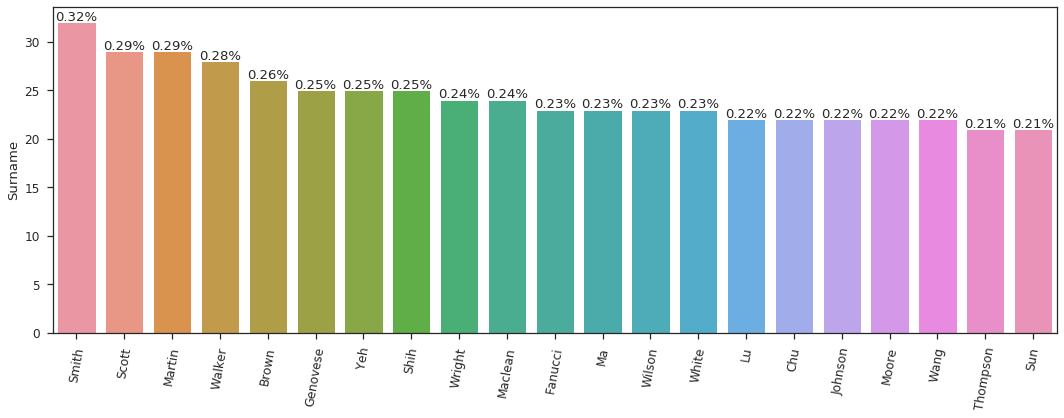

In [33]:
# Barplot for "Surname"
top20_surnames = df['Surname'].value_counts().reset_index().iloc[0:21, ]

sns.set({'figure.figsize': (18, 6)})
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_context("notebook", font_scale = 1.1)
total = float(len(df))
ax = sns.barplot(x = "index", y = "Surname", order = top20_surnames['index'], data = top20_surnames)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + .2, '{:1.2f}'.format(100 * height / total) + "%", ha = "center")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 80)
ax.set(xlabel = None);

- Just as a curiosity, the frequency of repeated surnames is shown above. The top 05 repeated surnames are 'Smith', 'Scott', 'Martin', 'Walker' and 'Brown' - which are quite common last names.

#### 1.2 - Eliminate Unique Features

In [34]:
# Dropping 'RowNumber', 'CustomerId' and 'Surname' from the Dataset
df.drop(columns = ['RowNumber', 'CustomerId', 'Surname'], inplace = True)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


- 'RowNumber', 'CustomerId' and 'Surname' variables were deleted from the dataset.

#### 1.3 - Check Unique Categories for Categorical Nominal and Numeric Discrete Variables with Fewers Categories

In [35]:
# Check Uniques Categories Values per Variable
# Including the Dependent Variable: 'Exited'
# Including Numeric/Discrete variables with less categories: 'Tenure', 'NumOfProducts', 'HasCrCard' and 'IsActiveMember' 
# Including Categorical/Nominal variables: 'Geography' and 'Gender'
cat_cols = ['Exited', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Geography', 'Gender']

for column in cat_cols :
    print(df[column].value_counts(normalize = True))
    print()
    print('-'*30)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

------------------------------
2     0.1048
1     0.1035
7     0.1028
8     0.1025
5     0.1012
3     0.1009
4     0.0989
9     0.0984
6     0.0967
10    0.0490
0     0.0413
Name: Tenure, dtype: float64

------------------------------
1    0.5084
2    0.4590
3    0.0266
4    0.0060
Name: NumOfProducts, dtype: float64

------------------------------
1    0.7055
0    0.2945
Name: HasCrCard, dtype: float64

------------------------------
1    0.5151
0    0.4849
Name: IsActiveMember, dtype: float64

------------------------------
France     0.5014
Germany    0.2509
Spain      0.2477
Name: Geography, dtype: float64

------------------------------
Male      0.5457
Female    0.4543
Name: Gender, dtype: float64

------------------------------


- 'Exited' is the Dependent Variable for the Classification model and reflects whether the Customers would be leaving the bank in the next 06 months. It is a Numeric/Discrete variable with 02 categories ('0' and '1'), however this variable can also be considered as being Categorical/Boolean having 02 distinct categories: '0' (existing Customer) and '1' (attrited Customer)'. There is a relevant imbalance on the 'Exited' categories, with 79.63% of data associated with '0' (existing Customer) and 20.37% of the data associated with '1' (attrited Customer)'.

- 'Tenure' is a Numerical/Discrete variable with 11 distinct categories ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', and '10'). This variable represents the period of time (assumed to be in years) a Customer has been associated with the bank.

- 'NumOfProducts' is a Numerical/Discrete variable with 04 distinct categories ('1', '2', '3' and '4'). This variable represents the number of affiliated products (including accounts) a Customer has with the bank.

- 'HasCrCard' is a Numeric/Discrete variable with only 02 categories ('0' and '1'). This variable can also be considered as being Categorical/Boolean since the 02 categories could be represented by 'not owning a credit card' and 'owning a creadit card'.

- 'IsActiveMember' is a Numeric/Discrete variable with only 02 categories ('0' and '1'). This variable can also be considered as being Categorical/Boolean since the 02 categories could be represented by 'is not an active member' and 'is an active member'. Being an active member means that the Customer is regularly using the bank products, making transactions, etc.

- 'Geography' is a Categorical/Nominal variable, having 03 distinct categories ('France', 'Germany' and 'Spain').

- 'Gender' is a Categorical/Nominal variable, having 02 distinct categories ('Female' and 'Male').

***
## 2 - Perform an Exploratory Data Analysis on the Data<a class="anchor" id="2222"></a>

<span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:blue;">

- Bivariate analysis
- Use appropriate visualizations to identify the patterns and insights
- Come up with a Customer profile (characteristics of a Customer) of the different packages
- Any other exploratory deep dive

#### 2.1 - Univariate Analysis for Numeric/Continuous Variables

##### Univariate Analysis for 'EstimatedSalary'

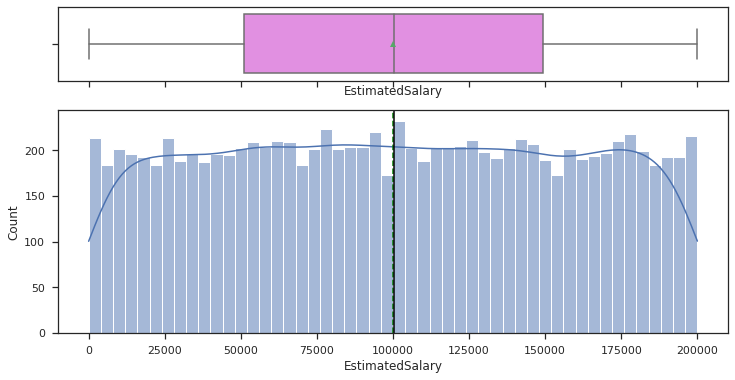

In [36]:
histogram_boxplot(df['EstimatedSalary'])

In [37]:
# Checking Descriptive Statistics and Skewness for 'EstimatedSalary'
print(df[['EstimatedSalary']].describe())
print()
print('Skewness', df[['EstimatedSalary']].skew())

       EstimatedSalary
count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000

Skewness EstimatedSalary    0.002085
dtype: float64


- 'EstimatedSalary' is a Numeric/Continuous variable and has a range from \\$11.58 to \\$199992.48, a mean and median at \\$100090.23 and \\$100193.92, respectively. Also, its distribution is very close to a continuous uniform (rectangular) distribution (skewness of 0.002).

##### Univariate Analysis for 'Balance'

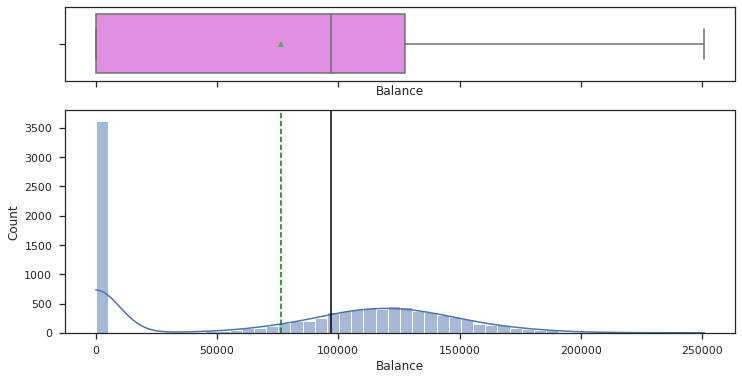

In [38]:
histogram_boxplot(df['Balance'])

In [39]:
# Top 10 Highest Values for 'Balance'
df['Balance'].nlargest(n = 5)

2092    250898.09
3280    238387.56
8733    222267.63
3588    221532.80
6717    216109.88
Name: Balance, dtype: float64

In [40]:
# Top 10 Lowest Values for 'Balance'
df['Balance'].nsmallest(n = 5)

0     0.0
3     0.0
6     0.0
11    0.0
12    0.0
Name: Balance, dtype: float64

In [41]:
print("There are {} data entries with 'Balance' of $0, representing {}% of the total entries".format(len(df[(df['Balance'] == 0)]),
                                                                                                     round(100 * len(df[(df['Balance'] == 0)]) / len(df), 2)))

There are 3617 data entries with 'Balance' of $0, representing 36.17% of the total entries


In [42]:
# Checking Descriptive Statistics and Skewness for 'Total_Revolving_Bal'
print(df[['Balance']].describe())
print()
print('Skewness', df[['Balance']].skew())

             Balance
count   10000.000000
mean    76485.889288
std     62397.405202
min         0.000000
25%         0.000000
50%     97198.540000
75%    127644.240000
max    250898.090000

Skewness Balance   -0.141109
dtype: float64


- 'Balance' is a Numeric/Continuous variable and has a range from \\$0.0 to \\$250898.09, a mean and median at \\$76485.89 and \\$97198.54, respectively. Also, its distribution doesn't exhibit a relevant degree of skewness (skewness of -0.14).

- There are 3617 data entries with 'Balance' of \\$0, representing 36.17\% of the total entries. This means 36.17\% of the Customers from this dataset didn't have any money deposited in their bank accounts.

- Because of the higher percentage of Customers with zero balance, the distribution looks bi-modal in shape, with 02 distinct peaks.

#### 2.2 - Univariate Analysis for Numeric/Discrete Variables with Several Categories

##### Univariate Analysis for 'CreditScore'

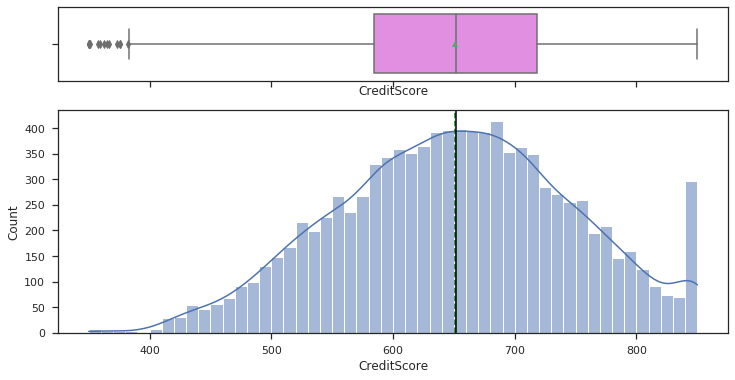

In [43]:
histogram_boxplot(df['CreditScore'])

In [44]:
# Top 10 Highest Values for 'CreditScore'
df['CreditScore'].nlargest(n = 5)

4      850
38     850
180    850
200    850
223    850
Name: CreditScore, dtype: int64

In [45]:
print("There are {} data entries with 'CreditScore' of 850, representing {}% of the total entries".format(len(df[(df['CreditScore'] == 850)]),
                                                                                                          round(100 * len(df[(df['CreditScore'] == 850)]) / len(df), 2)))

There are 233 data entries with 'CreditScore' of 850, representing 2.33% of the total entries


In [46]:
# Checking Descriptive Statistics and Skewness for 'CreditScore'
print(df[['CreditScore']].describe())
print()
print('Skewness', df[['CreditScore']].skew())

        CreditScore
count  10000.000000
mean     650.528800
std       96.653299
min      350.000000
25%      584.000000
50%      652.000000
75%      718.000000
max      850.000000

Skewness CreditScore   -0.071607
dtype: float64


- 'CreditScore' is a Numeric/Discrete variable with only several categories and has a range from 350 to 850, a mean and median at 650.53 and 652.00, respectively. Also, its distribution looks very close to a normal distribution with minimal skewness (skewness of -0.07).

- The upper limit for the 'CreditScore' ditribution was capped at 850 since FICO scores range from 350 to 850. There are 233 data entries with 'CreditScore' of 850, representing 2.33\% of the total entries.

- An additional piece of information is that FICO scores under 580 is considered poor credit and 740 or higher is considered very good or exceptional credit.

##### Univariate Analysis for 'Age'

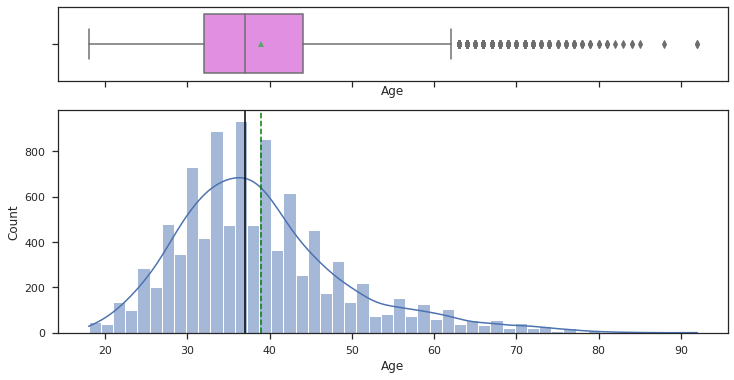

In [47]:
histogram_boxplot(df['Age'])

In [48]:
# Checking Descriptive Statistics and Skewness for 'Age'
print(df[['Age']].describe())
print()
print('Skewness', df[['Age']].skew())

                Age
count  10000.000000
mean      38.921800
std       10.487806
min       18.000000
25%       32.000000
50%       37.000000
75%       44.000000
max       92.000000

Skewness Age    1.01132
dtype: float64


- 'Age' is a Numeric/Discrete variable with only several categories and has a range from 18 to 92, a mean and median at 38.92 and 37.00, respectively. Also, its distribution is skewed to the right (skewness of 1.01).

#### 2.3 - Univariate/Bivariate Analysis for Numeric/Discrete Variables with Fewer Categories

##### Univariate/Bivariate Analysis for 'Tenure'

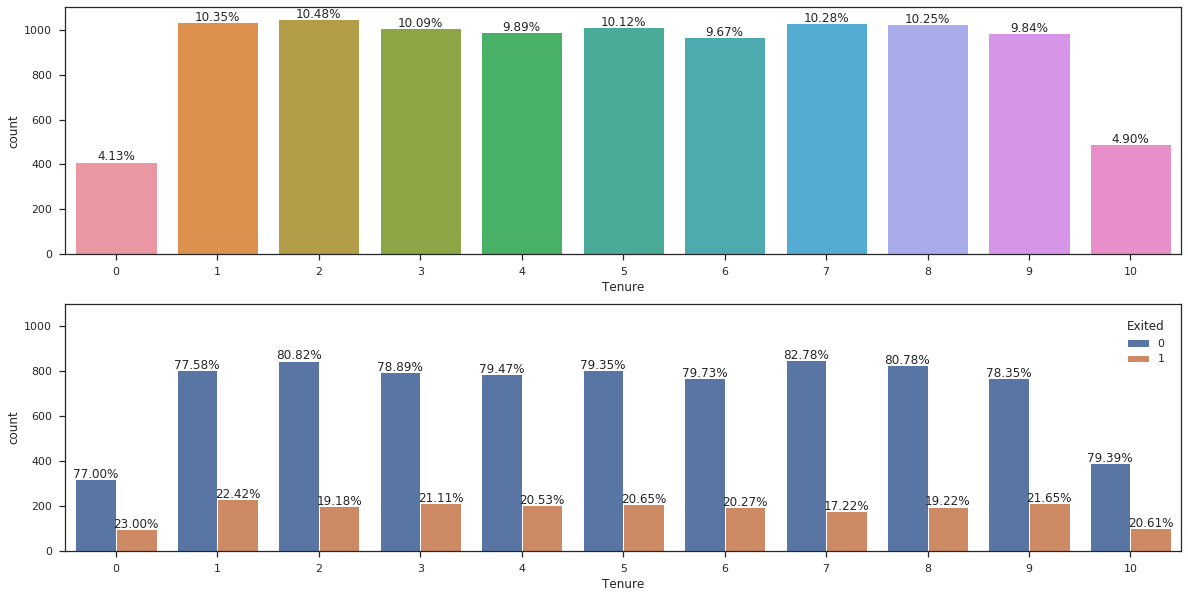

In [49]:
# Combo Countplot with overall Percentages (top graph) and Percentages Split on 'Exited' within each Category (bottom graph)
percentage_on_bar(feature = "Tenure", hue = "Exited", data = df, order = None, hue_order = None)

- 'Tenure' of '0' and '10' are less frequent in the dataset, with 4.13% and 4.90% respectively. All the other categories of 'Tenure' (from '1' to '9') with similar frequencies in the dataset - range from 9.67% to 10.48%.

- All categories presented approximate similar percentages of exited Customers (range from 17.22% to 22.42%).

##### Univariate/Bivariate Analysis for 'NumOfProducts'

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


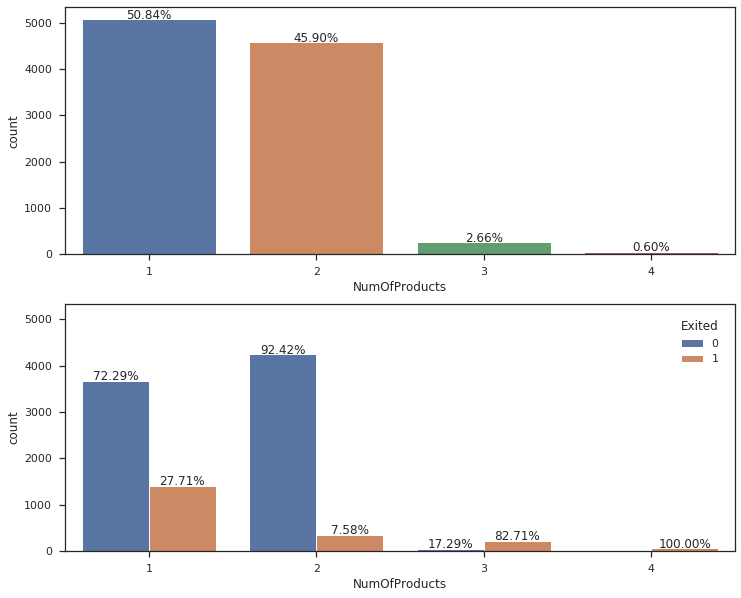

In [50]:
# Combo Countplot with overall Percentages (top graph) and Percentages Split on 'Attrition_Flag' within each Category (bottom graph)
percentage_on_bar(feature = "NumOfProducts", hue = "Exited", data = df, order = None, hue_order = None, size = (12, 10))

- 'NumOfProducts' of '1' and '2' are more frequent in the dataset, with 50.84% and 45.90% of contribution, respectively.

- 'NumOfProducts' of '4' is negligible, with only 0.60% of occurrences in the dataset. 

- 'NumOfProducts' of '3' is also underrepresented in the dataset with 2.66% of the occurrences, however the amount of exited Customers in this category is much higher (82.71%) compared to the frequengy of exited Customers in the categories '1' and '2'.

- 'NumOfProducts' of '2' takes much less exited Customers than the other categories, with exiting frequency of 7.58%. The category '1', which is also very frequent in the dataset (50.84% of the occurrences) has 27.71% of exited Customers.

- Based on these information, the 'NumOfProducts' is expected to have more relevant contribution in the classification model.

##### Univariate/Bivariate Analysis for 'HasCrCard'

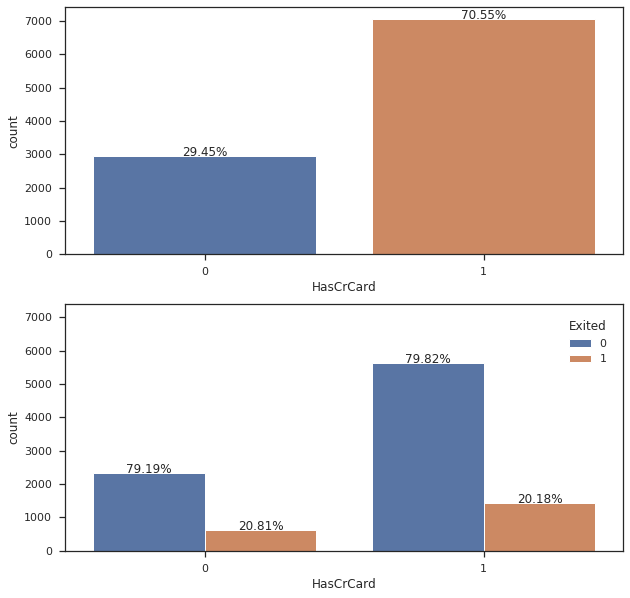

In [51]:
# Combo Countplot with overall Percentages (top graph) and Percentages Split on 'Attrition_Flag' within each Category (bottom graph)
percentage_on_bar(feature = "HasCrCard", hue = "Exited", data = df, order = None, hue_order = None, size = (10, 10))

- Customers who have a credit card thru the bank ('HasCrCard' of '1') are more frequent in the dataset, with 70.55% of the occurrences.

- Both categories '0' and '1' (Customer doesn't have a credit card and Customer has a credit card, respectively) present a similar percentage of exited Customers (range from 20.18% to 20.81%).

##### Univariate/Bivariate Analysis for 'IsActiveMember'

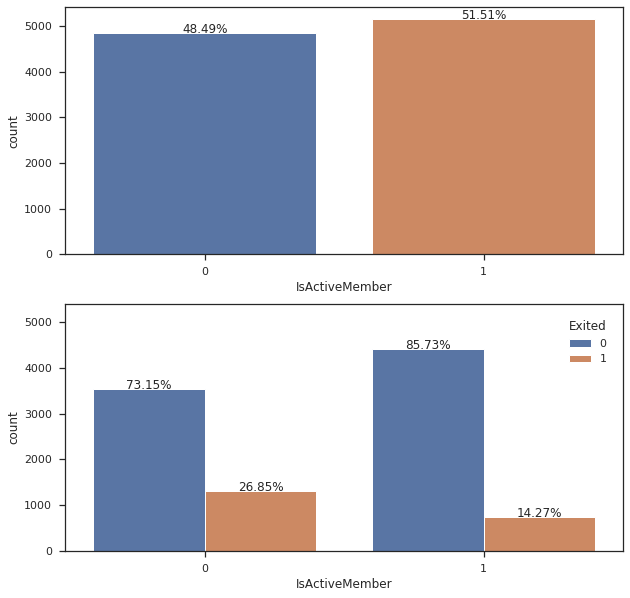

In [52]:
# Combo Countplot with overall Percentages (top graph) and Percentages Split on 'Attrition_Flag' within each Category (bottom graph)
percentage_on_bar(feature = "IsActiveMember", hue = "Exited", data = df, order = None, hue_order = None, size = (10, 10))

- Either inactive Customers ('IsActiveMember' at '0') and active Customers ('IsActiveMember' at '1') have very similar frequencies in the dataset, with 48.49% and 51.51% of occurrence, respectively. 

- Inactive Customers are more likely to turn into exited Customers (26.85%) when compared to active Customers (14.27%). This reinforces the fact that if the Customers are regularly using the bank products (active Customers), then they are less likely to exit. Based on these trends, the Customer activity with the bank products is expected to have a certain importance to the classification model.

#### 2.4 - Univariate/Bivariate Analysis for Categorical/Nominal Variables

##### Univariate Analysis for 'Exited'

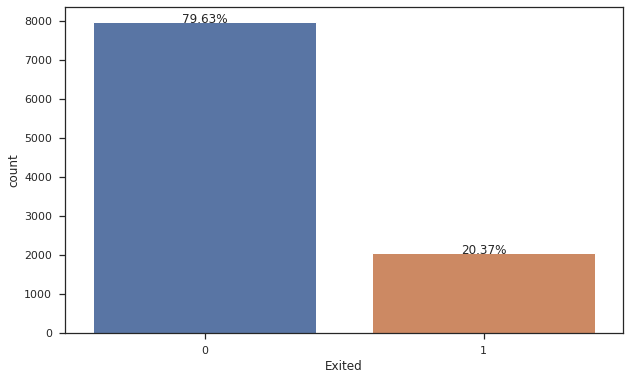

In [53]:
# Countplot with Overall Percentages
feature = df['Exited']
sns.set({'figure.figsize': (10, 6)})
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_context("notebook")
total = len(feature)
ax = sns.countplot(x = feature, data = df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 5, '{:1.2f}'.format(100 * height / total) + "%", ha = "center")

- As mentioned before, 'Exited' has a relevant class imbalance between the classes 0 ('Existing Customer') and 1 ('Exited Customer'), with 79.63% and 20.37% of the data allocated to classes '0' and '1', respectively. Because of that, a technique to compensate the classes imbalance is recommended to be explored for the Classification models.

##### Univariate/Bivariate Analysis for 'Geography'

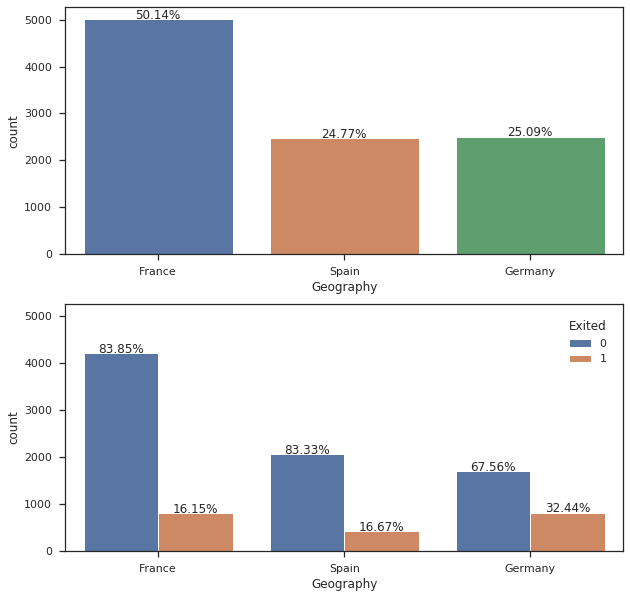

In [54]:
# Combo Countplot with overall Percentages (top graph) and Percentages Split on 'Attrition_Flag' within each Category (bottom graph)
percentage_on_bar(feature = "Geography", hue = "Exited", data = df, order = None, hue_order = None, size = (10, 10))

- Customers from 'France' (50.14%) are approximate twice more frequent in the dataset when compared to Customers from 'Spain' (24.77%) and 'Germany' (25.09%).

- Customers from 'Germany' are approximate twice more likely (32.44%) to exit the bank services compared to Customers from 'France' (16.15%) and 'Spain' (16.67%). Based on these trends, the Customer Geography is expected to be an influentional varible to the classification model.

##### Univariate/Bivariate Analysis for 'Gender'

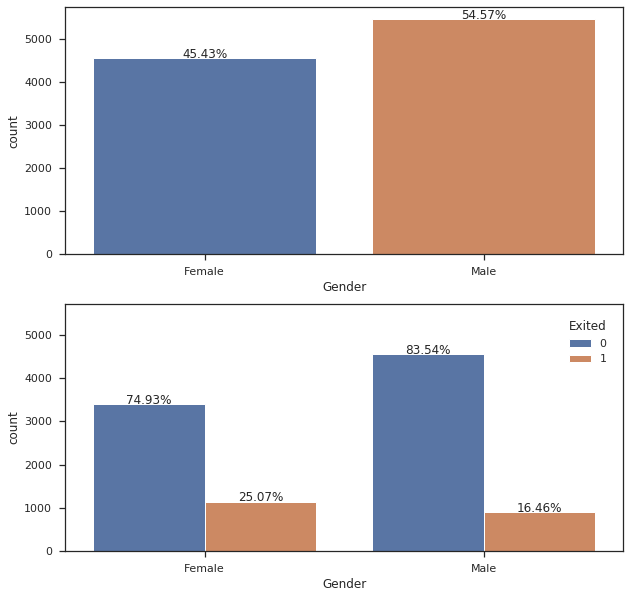

In [55]:
# Combo Countplot with overall Percentages (top graph) and Percentages Split on 'Attrition_Flag' within each Category (bottom graph)
percentage_on_bar(feature = "Gender", hue = "Exited", data = df, order = None, hue_order = None, size = (10, 10))

- Male Customers (54.57%) are more frequent in the dataset than Female Customers (45.43%).

- Female Customers are more likely to exit the bank services than Male Customers - Female is 25.07% likely to exit and Male is 16.46% likely to exit the bank services. Based on these trends, the Customer Gender is expected to have a certain contribution in the classification model.

#### 2.5 - Bivariate Analysis for Numeric/Continuous Variables and Numeric/Discrete Variables with Several Categories

In [56]:
# Numeric/Continuous and Numeric/Discrete Variables with Several Categories
num_vars = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Exited']

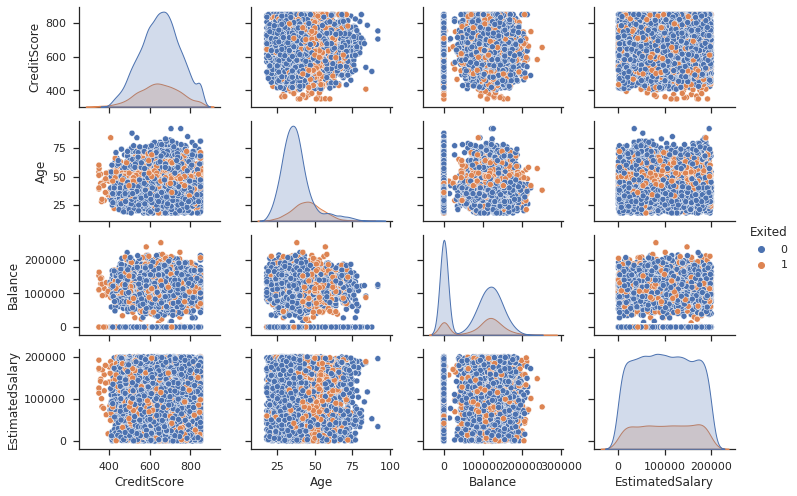

In [57]:
# Bivariate Analysis - Pairplot for Numeric/Continuous and Numerical/Discrete Variables with Several Categories
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("notebook")
sns.pairplot(data = df[num_vars], hue = 'Exited', height = 1.75, aspect = 1.5, corner = False);

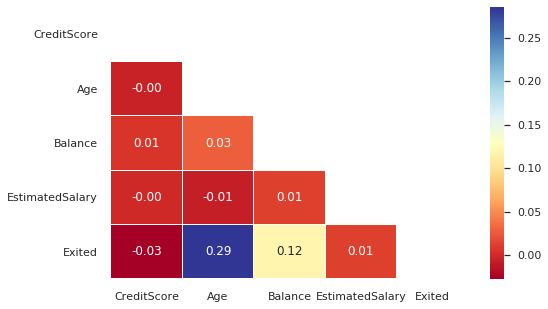

In [58]:
# Bivariate Analysis - Heatmap for Numeric/Continuous and Numerical/Discrete Variables with Several Categories
sns.set({'figure.figsize': (8, 5)})
sns.set_style("whitegrid")
corr = df[num_vars].corr()
lower_triangle = np.tril(corr, k = -1)
sns.set_context("notebook")
mask = lower_triangle == 0
g = sns.heatmap(df[num_vars].corr(), annot = True, cmap = "RdYlBu", fmt = '.2f', linewidths = 0.05, mask = mask)
g.set_ylim(5, 0);

- Looking at the Heatmap, 'Age' and 'Balance' have some degree of association (positive correlation of 0.29 and 0.12, respectively) with the target variable 'Exited'. The 02 following plots will show the relationship between 'Age' and 'Balance' with the dependent variable ('Exited') in more details.

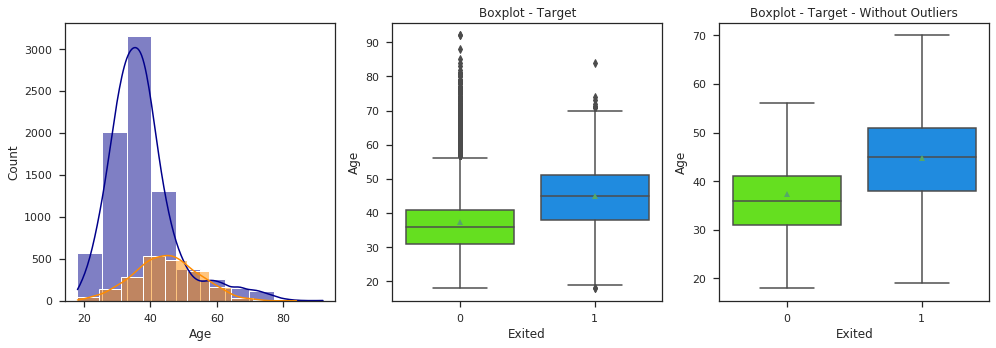

In [59]:
# Histogram and Boxplots with Hue on the Target Value for 'Age'
combo_plot(feature = 'Age', target = 'Exited', data = df, nbins = 10)

- On average, older Customers are more likely to exit the bank services.

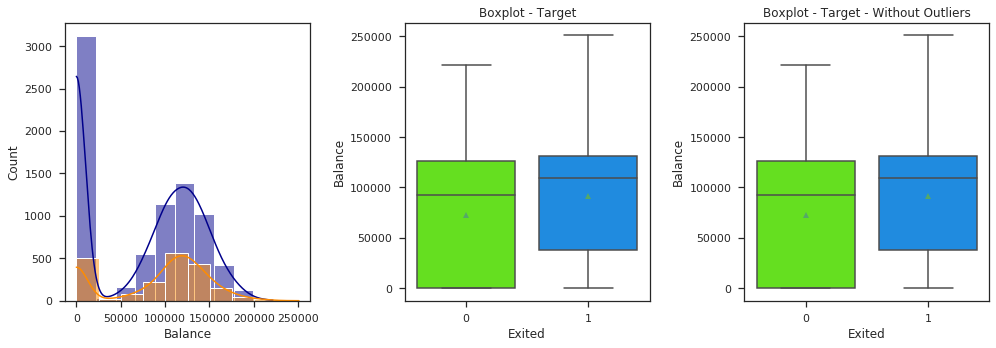

In [60]:
# Histogram and Boxplots with Hue on the Target Value for 'Balance'
combo_plot(feature = 'Balance', target = 'Exited', data = df, nbins = 10)

- Customers with more money deposited in their bank accounts (higher 'Balance') are on average more likely to exit the bank services.

#### 2.6 - Customer Profile

##### Data Preparation before Clustering Analysis

In [61]:
# Creating a copy for the dataset to run the Clustering Analysis
df_profile = df.copy()

In [62]:
# Data preparation for the Clustering Analysis
# Converting 'Gender' to Numeric Discrete and Hot-encodign 'Georgraphy'
df_profile['Gender'] = df_profile['Gender'].map(lambda x: {'Female' : 0, 'Male' : 1}.get(x))
df_profile = pd.get_dummies(df_profile, columns = ['Geography'], prefix = "Geo")

In [63]:
# Dropping the Dependend Variable 'Exited' from the Dataset
df_profile.drop(columns = ['Exited'], inplace = True)

In [64]:
# Standardization using "scipy.stats import zscore"
df_profile_std = df_profile.apply(zscore)

In [65]:
# Final dataset for Clustering Analysis
df_profile_std.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geo_France,Geo_Germany,Geo_Spain
0,-0.326221,-1.095988,0.293517,-1.041760,-1.225848,-0.911583,0.646092,0.970243,0.021886,0.997204,-0.578736,-0.573809
1,-0.440036,-1.095988,0.198164,-1.387538,0.117350,-0.911583,-1.547768,0.970243,0.216534,-1.002804,-0.578736,1.742740
2,-1.536794,-1.095988,0.293517,1.032908,1.333053,2.527057,0.646092,-1.030670,0.240687,0.997204,-0.578736,-0.573809
3,0.501521,-1.095988,0.007457,-1.387538,-1.225848,0.807737,-1.547768,-1.030670,-0.108918,0.997204,-0.578736,-0.573809
4,2.063884,-1.095988,0.388871,-1.041760,0.785728,-0.911583,0.646092,0.970243,-0.365276,-1.002804,-0.578736,1.742740


- Since the variables of interest have different scales/dimensions, the dataset was standardized using z-scores before proceeding with any clustering methods.

##### Applying K-means and Elbow Curve

In [66]:
# Instantiating the clustering model and visualizer
model = KMeans(random_state = seed)

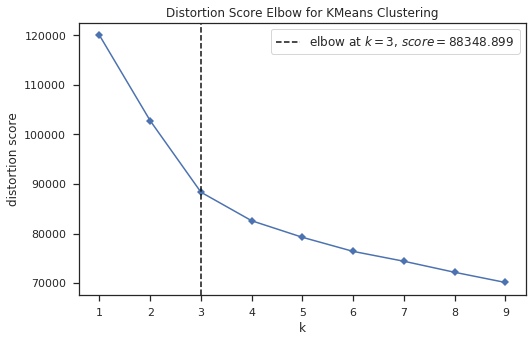

In [67]:
# Using the "KElbowVisualizer" from the "yellowbrick" library to create the Elbow Curve (metric = 'distortion')
visualizer = KElbowVisualizer(model, k = (1, 10), locate_elbow = True, metric = 'distortion', timings = False)
visualizer.fit(df_profile_std)
visualizer.show();

- The appropriate number of clusters (k) seems to be at 03, where the "elbow" can be visualized at the plot above.

##### Silhouette Score for K-means

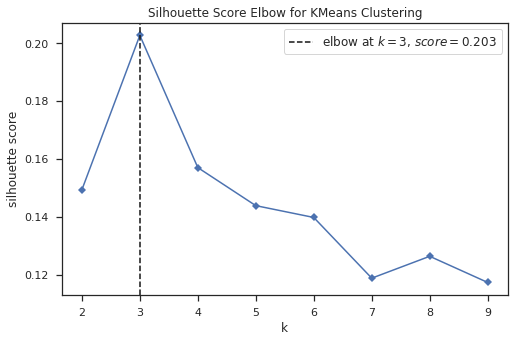

In [68]:
# Using the "KElbowVisualizer" from the "yellowbrick" library to create the Silhouette Scores for multiple number of clusters (metric = 'silhouette')
# Calculating the Silhouette Coefficients for multiple number of clusters (k).
# The Silhouette Score is used to evaluate the density and separation between clusters
# The Silhouette Coefficient is computed by averaging the silhouette coefficient for each sample.
# This is calculated as the difference between the average intra-cluster distance and the mean nearest-cluster distance for each sample, normalized by the maximum value. 

visualizer = KElbowVisualizer(model, k = (2, 10), locate_elbow = True, metric = 'silhouette', timings = False)
visualizer.fit(df_profile_std)
visualizer.show();

- Silhouette Score can be between 1 and -1, where 1 is highly dense clusters and -1 is completely incorrect clustering. Values near 0 indicate overlapping clusters. 
- On the plot above, k = 3 (03 clusters) is associated with the highest Silhouette Score, meaning that 03 clusters represents the best choice.

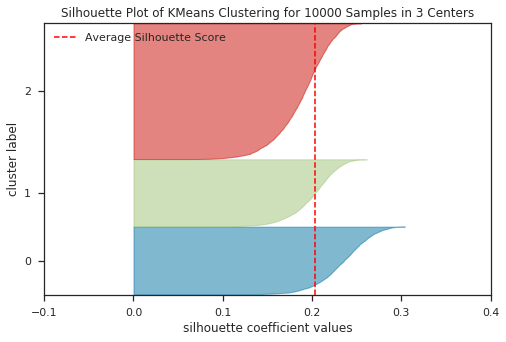

In [69]:
# SiLhouette Plot for 03 clusters 
visualizer = SilhouetteVisualizer(KMeans(3, random_state = seed), colors = 'yellowbrick')
visualizer.fit(df_profile_std)
visualizer.show();

- Looking at the Silhouette plot above (03 clusters),  the Silhouette Score for each cluster is above the average (red dash line), and the fluctuation in size (width) looks similar. This reinforces the fact that 03 clusters is a good choice.

##### Initial Insights about Customer Segmentation using K-Means Clustering

In [70]:
# Creating the final model with 03 clusters
final_model = KMeans(n_clusters = 3, random_state = seed)
final_model.fit(df_profile_std)
prediction = final_model.predict(df_profile_std)

In [71]:
# Appending the respective centroid-based clusters (K-means Cluster) for each data row to the original dataset 
df_profile['Cluster'] = prediction

In [72]:
# Creating insights about the Customer profile by grouping the original dataset by cluster
# Adding the counts and percentages for each segment in the grouped data table
cluster_profile_Kmeans = df_profile.groupby('Cluster').mean()
cluster_profile_Kmeans['# of Entries'] = df_profile.groupby('Cluster')['CreditScore'].count()
cluster_profile_Kmeans['%'] = round(100 * df_profile.groupby('Cluster')['CreditScore'].count() / len(df), 1).astype(str) + '%'

In [73]:
# Displaying Cluster profile
cluster_profile_Kmeans.style.highlight_min(color = 'red', axis = 0).highlight_max(color = 'lightgreen', axis = 0)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geo_France,Geo_Germany,Geo_Spain,# of Entries,%
Cluster,,,,,,,,,,,,,,
0,651.453567,0.524512,39.771622,5.009964,119730.116134,1.519729,0.713830,0.497409,101113.435102,0,1,0,2509,25.1%
1,651.333872,0.560355,38.890997,5.032297,61818.147763,1.539362,0.694792,0.529673,99440.572281,0,0,1,2477,24.8%
2,649.668329,0.549063,38.511767,5.004587,62092.636516,1.530913,0.706621,0.516753,99899.180814,1,0,0,5014,50.1%


- Looking at the table above, the first cluster (K-means Cluster = 0) represents around 25.1% of the data entries. It encompasses the Customers from "Germany" and with higher "Balance".

- Looking at the table above, the second cluster (K-means Cluster = 1) represents around 24.8% of the data entries. It encompasses the Customers from "Spain" and with lower "Balance".

- Looking at the table above, the third cluster (K-means Cluster = 2) represents around 50.1% of the data entries. It encompasses the Customers from "France" and with lower "Balance".

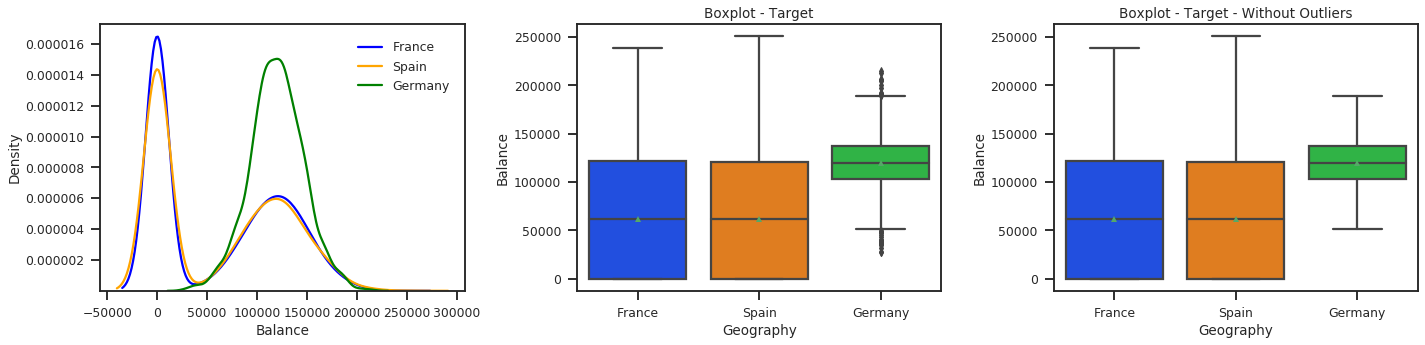

In [74]:
# KDE Plot and Boxplots showing the relationship between Customer Geography and Balance

sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_context("talk", font_scale = 0.75)
    
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
     
sns.kdeplot(df[(df['Geography'] == 'France')]['Balance'], ax = axs[0], color = 'blue')
sns.kdeplot(df[(df['Geography'] == 'Spain')]['Balance'], ax = axs[0], color = 'orange')
sns.kdeplot(df[(df['Geography'] == 'Germany')]['Balance'], ax = axs[0], color = 'green')
# bbox_to_anchor (x, y, width, height), where (x0,y0) are the lower left corner coordinates of the bounding box
fig.legend(labels=['France','Spain', 'Germany'], bbox_to_anchor = (0, 0, 0.32, 0.875))
       
axs[1].set_title('Boxplot - Target')
sns.boxplot(df['Geography'], df['Balance'], ax = axs[1], palette = 'bright', showmeans = True)
axs[2].set_title('Boxplot - Target - Without Outliers')
sns.boxplot(df['Geography'], df['Balance'], ax = axs[2], showfliers = False, palette = 'bright', showmeans = True)
plt.tight_layout();

##### Insights about Different Clusters

- **Cluster 0 - German Customers & Higher Balance**: this cluster is related to Customers from Germany who have higher amount of money deposited in their bank accounts (average of \\$120000). Apparently, German Customers are not likely to keep their bank accounts with zero balance as the Customers from Spain and France.
    
- **Cluster 1 - Spanish Customers & Lower Balance**: this cluster is related to Customers from Spain who have lower amount of money deposited in their bank accounts (average of \\$62000).
    
- **Cluster 2 - French Customers & Lower Balance**: this cluster is related to Customers from France who have lower amount of money deposited in their bank accounts (average of \\$62000).

##### Important Remarks about K-Means Clustering usage for a mix of Continous and Categorical Data

- Following the guidance I got from the Academic Team, there are some implications about using K-Means Clustering for a mix of Continuous and Categorical data.

- The sample space for categorical data is discrete and doesn't have a natural origin. A Euclidean distance function on such a space isn't really meaningful. There's a variation of K-Means known as K-Modes, which is suitable for categorical data. However the solutions are sensitive to initial conditions.

- There's another variation called K-Prototypes which applies to data with a mix of Categorical and Numeric features. It uses a distance measure which mixes the Hamming distance for Categorical features and the Euclidean distance for Numeric features.

- The approach utilized in this session (conversion of Categorical variables to binary values or hot-encoding, and doing K-Means as if these were numeric values) is another approach that has been tried before (predating K-Modes). I understand that this approach has its limitations, however for the sake of delivering this project I'll keep that. As a sense checking, I also believe the results I got by using this approach are meaninful, since they allowed me to find a pattern in the dataset that I couldn't identify thru my regular EDA.

***
## 3 - Illustrate the Insights based on EDA <a class="anchor" id="3333"></a>

<span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:blue;">
- Key meaningful observations from Bivariate analysis

Summary for the key insights from EDA (all graphs and other details were covered at the previous sessions):

- 'Exited' is the Dependent Variable for the Classification model and reflects whether the Customers would be leaving the bank in the next 06 months. It is a Numeric/Discrete variable with 02 categories ('0' and '1'), however this variable can also be considered as being Categorical/Boolean having 02 distinct categories: '0' (existing Customer) and '1' (attrited Customer)'. There is a relevant imbalance on the 'Exited' categories, with 79.63% of data associated with '0' (existing Customer) and 20.37% of the data associated with '1' (attrited Customer)'. Because of that, a technique to compensate the classes imbalance is recommended to be explored for the Classification models.

- 'Tenure' is a Numerical/Discrete variable with 11 distinct categories ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', and '10'). This variable represents the period of time (assumed to be in years) a Customer has been associated with the bank. 'Tenure' of '0' and '10' are less frequent in the dataset, with 4.13% and 4.90% respectively. All the other categories of 'Tenure' (from '1' to '9') with similar frequencies in the dataset - range from 9.67% to 10.48%. All categories presented approximate similar percentages of exited Customers (range from 17.22% to 22.42%).

- 'NumOfProducts' is a Numerical/Discrete variable with 04 distinct categories ('1', '2', '3' and '4'). This variable represents the number of affiliated products (including accounts) a Customer has with the bank. 'NumOfProducts' of '1' and '2' are more frequent in the dataset, with 50.84% and 45.90% of contribution, respectively. 'NumOfProducts' of '4' is negligible, with only 0.60% of occurrences in the dataset. 'NumOfProducts' of '3' is also underrepresented in the dataset with 2.66% of the occurrences, however the amount of exited Customers in this category is much higher (82.71%) compared to the frequengy of exited Customers in the categories '1' and '2'. 'NumOfProducts' of '2' takes much less exited Customers than the other categories, with exiting frequency of 7.58%. The category '1', which is also very frequent in the dataset (50.84% of the occurrences) has 27.71% of exited Customers.  Based on these information, the 'NumOfProducts' is expected to have more relevant contribution in the classification model.

- HasCrCard' is a Numeric/Discrete variable with only 02 categories ('0' and '1'). This variable can also be considered as being Categorical/Boolean since the 02 categories could be represented by 'not owning a credit card' and 'owning a creadit card'. Customers who have a credit card thru the bank ('HasCrCard' of '1') are more frequent in the dataset, with 70.55% of the occurrences. Both categories '0' and '1' (Customer doesn't have a credit card and Customer has a credit card, respectively) present a similar percentage of exited Customers (range from 20.18% to 20.81%).

- 'IsActiveMember' is a Numeric/Discrete variable with only 02 categories ('0' and '1'). This variable can also be considered as being Categorical/Boolean since the 02 categories could be represented by 'is not an active member' and 'is an active member'. Being an active member means that the Customer is regularly using the bank products, making transactions, etc. Either inactive Customers ('IsActiveMember' at '0') and active Customers ('IsActiveMember' at '1') have very similar frequencies in the dataset, with 48.49% and 51.51% of occurrence, respectively. Inactive Customers are more likely to turn into exited Customers (26.85%) when compared to active Customers (14.27%). This reinforces the fact that if the Customers are regularly using the bank products (active Customers), then they are less likely to exit. Based on these trends, the Customer activity with the bank products is expected to have a certain importance to the classification model.

- 'Geography' is a Categorical/Nominal variable, having 03 distinct categories ('France', 'Germany' and 'Spain'). Customers from 'France' (50.14%) are approximate twice more frequent in the dataset when compared to Customers from 'Spain' (24.77%) and 'Germany' (25.09%). Customers from 'Germany' are approximate twice more likely (32.44%) to exit the bank services compared to Customers from 'France' (16.15%) and 'Spain' (16.67%). Based on these trends, the Customer Geography is expected to be an influentional varible to the classification model.

- 'Gender' is a Categorical/Nominal variable, having 02 distinct categories ('Female' and 'Male'). Male Customers (54.57%) are more frequent in the dataset than Female Customers (45.43%). Female Customers are more likely to exit the bank services than Male Customers - Female is 25.07% likely to exit and Male is 16.46% likely to exit the bank services. Based on these trends, the Customer Gender is expected to have a certain contribution in the classification model.

- 'EstimatedSalary' is a Numeric/Continuous variable and has a range from \\$11.58 to \\$199992.48, a mean and median at \\$100090.23 and \\$100193.92, respectively. Also, its distribution is very close to a continuous uniform (rectangular) distribution (skewness of 0.002).

- 'Balance' is a Numeric/Continuous variable has a range from \\$0.0 to \\$250898.09, a mean and median at \\$76485.89 and \\$97198.54, respectively. Also, its distribution doesn't exhibit a relevant degree of skewness (skewness of -0.14). There are 3617 data entries with 'Balance' of \\$0, representing 36.17\% of the total entries. This means 36.17\% of the Customers from this dataset didn't have any money deposited in their bank accounts. Because of the higher percentage of Customers with zero balance, the distribution looks bi-modal in shape, with 02 distinct peaks.

- 'CreditScore' is a Numeric/Discrete variable with only several categories and has a range from 350 to 850, a mean and median at 650.53 and 652.00, respectively. Also, its distribution looks very close to a normal distribution with minimal skewness (skewness of -0.07). The upper limit for the 'CreditScore' ditribution was capped at 850 since FICO scores range from 350 to 850. There are 233 data entries with 'CreditScore' of 850, representing 2.33\% of the total entries. An additional piece of information is that FICO scores under 580 is considered poor credit and 740 or higher is considered very good or exceptional credit.

- 'Age' is a Numeric/Discrete variable with only several categories and has a range from 18 to 92, a mean and median at 38.92 and 37.00, respectively. Also, its distribution is skewed to the right (skewness of 1.01).

- As per the presented Heatmap ate the EDA session, 'Age' and 'Balance' have some degree of association (positive correlation of 0.29 and 0.12, respectively) with the target variable 'Exited'. On average, older Customers are more likely to exit the bank services. Also, Customers with more money deposited in their bank accounts (higher 'Balance') are on average more likely to exit the bank services.

- For the Customer Profile, 03 clusters were identified thru K-Means Clustering: 
    - Cluster 0 - German Customers & Higher Balance: Customers from Germany who have higher amount of money deposited in their bank accounts (average of \\$120000). Apparently, German Customers are not likely to keep their bank accounts with zero balance as the Customers from Spain and France.
    - Cluster 1 - Spanish Customers & Lower Balance: Customers from Spain who have lower amount of money deposited in their bank accounts (average of \\$62000).
    - Cluster 2 - French Customers & Lower Balance**: this cluster is related to Customers from France who have lower amount of money deposited in their bank accounts (average of \\$62000).

***
## 4. Data Pre-processing<a class="anchor" id="4444"></a>

<span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:blue;">
    
- Split the target variable and predictors
- Split the data into train and test
- Rescale the data

#### 4.1 - Encoding Categorical/Nominal Variables

In [75]:
# Creating a copy from the original dataset
data = df.copy()
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [76]:
# Hot-encoding for the Categorical/Nominal variables 
data = pd.get_dummies(data, columns = ['Geography', 'Gender'], drop_first = True)

- Dummy variables were created for the Categorical/Nominal variables. "drop_first = True" was applied to drop the first column for the hot-encoded variables. This is useful in situations where perfectly collinear features cause problems, such as when feeding the resulting data into a neural network or an unregularized regression. See reference on the link: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

In [77]:
data.head(10)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0
5,645,44,8,113755.78,2,1,0,149756.71,1,0,1,1
6,822,50,7,0.00,2,1,1,10062.80,0,0,0,1
7,376,29,4,115046.74,4,1,0,119346.88,1,1,0,0
8,501,44,4,142051.07,2,0,1,74940.50,0,0,0,1
9,684,27,2,134603.88,1,1,1,71725.73,0,0,0,1


- Dummy variables were created for all the Categorical/Nominal variables. The first hot-encoded column was decided to be dropped to play on the safe side or prevent any issues related to multi-colinearity.

- Data is now ready for the splitting into Train and Test sets.

#### 4.2 - Splitting the Data into Train and Test Sets

In [78]:
# Separating target variable and other variables
X = data.drop(columns = "Exited")
y = data["Exited"]

In [79]:
# Splitting the data into Train and Test sets
# Utilizing "stratify = y" to split the Train and Test sets in a stratified fashion
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = seed, stratify = y)
print(X_train.shape, X_test.shape)

(7000, 11) (3000, 11)


In [80]:
# Resulting Split into Training and Test Set (70:30 Ratio)
print("Original True Values  ('Exited'='1'): {0} ({1:0.2f}%)".format(len(data.loc[data['Exited'] == 1]), (len(data.loc[data['Exited'] == 1])/len(data.index)) * 100))
print("Original False Values ('Exited'='0'): {0} ({1:0.2f}%)".format(len(data.loc[data['Exited'] == 0]), (len(data.loc[data['Exited'] == 0])/len(data.index)) * 100))
print()
print("Training True Values  ('Exited'='1'): {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 1]), (len(y_train[y_train[:] == 1])/len(y_train)) * 100))
print("Training False Values ('Exited'='0'): {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 0]), (len(y_train[y_train[:] == 0])/len(y_train)) * 100))
print()
print("Test True Values      ('Exited'='1'):  {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 1]), (len(y_test[y_test[:] == 1])/len(y_test)) * 100))
print("Test False Values     ('Exited'='1'): {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 0]), (len(y_test[y_test[:] == 0])/len(y_test)) * 100))

Original True Values  ('Exited'='1'): 2037 (20.37%)
Original False Values ('Exited'='0'): 7963 (79.63%)

Training True Values  ('Exited'='1'): 1426 (20.37%)
Training False Values ('Exited'='0'): 5574 (79.63%)

Test True Values      ('Exited'='1'):  611 (20.37%)
Test False Values     ('Exited'='1'): 2389 (79.63%)


- Train and Test sets were created with 70% and 30% of the data, respectively.
- For the data splitting, a 'stratify = y' argument was utilized to create the splits with similar balance as per the target variable (as seen on the summary above).

#### 4.3 - Standardazing X_train and X_test

In [81]:
# Defining the Scaler 
scaler = sklearn.preprocessing.StandardScaler()

# Scaling the Train set
# "fit_transform()" is used on the Training data so that the Training data is scaled and also learn the scaling parameters of that data. 
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)

# Scale the Test set
# "transform()" is used on the Testing data. Thus, the parameters learned by our model using the Training data will help us to transform the Test data.
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [82]:
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,-1.385480,-0.938920,-1.035870,0.460208,-0.918448,0.645536,-1.033120,1.012113,-0.577350,-0.578230,-1.089725
1,0.979538,1.142223,-0.689110,0.367663,-0.918448,0.645536,0.967942,-1.235424,1.732051,-0.578230,0.917663
2,2.063934,2.561184,-0.342351,-1.215278,0.788704,-1.549099,0.967942,-0.615548,-0.577350,-0.578230,0.917663
3,-1.447445,-1.601102,-0.689110,1.287744,-0.918448,-1.549099,-1.033120,-0.965064,-0.577350,-0.578230,-1.089725
4,-1.137618,-0.749725,1.738206,0.670495,-0.918448,0.645536,0.967942,1.023469,-0.577350,1.729416,-1.089725


In [83]:
X_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,0.091365,0.007054,1.044687,0.480589,0.788704,0.645536,0.967942,1.724655,1.732051,-0.578230,0.917663
1,0.463158,1.331418,1.044687,0.304591,-0.918448,-1.549099,-1.033120,-0.514243,1.732051,-0.578230,-1.089725
2,0.545779,-0.938920,1.391447,-1.215278,0.788704,0.645536,-1.033120,-0.854748,-0.577350,1.729416,0.917663
3,0.514796,-0.182141,0.697928,-1.215278,0.788704,0.645536,-1.033120,-1.443307,-0.577350,-0.578230,-1.089725
4,1.795417,0.953028,1.044687,0.911051,-0.918448,0.645536,0.967942,-0.553705,1.732051,-0.578230,0.917663


- "fit_transform()" was used to scale the Training data, and "transform()" was used to scale the Testing data. This scaling process is the same approach that happens whne using Pipelines.

- Data is now ready for building the Classification models.

### 4.4 - Classification Models Evaluation Criteria

- Based on the Background and Context:
    
    "Businesses like banks that provide service have to worry about the problem of 'Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard."

- Because the bank is mostly interested in identifying the Customers who will leave and join another service provider, Recall is understood as being the most important metric here. Increasing the Recall will increase the amount of true positives and/or reduce the amount of false negatives, and that will reduce the chance to misclassify exited/attrited Customers as existing Customers.

- However, if strictly prioritizing the maximization for the Recall, that will trade the model Precision. This is not desired in the sense that increasing the number of false positives (or reducing the model Precision) that may also be harmful to the business. With that, the main emphasis here will be to build a model by using the ROC_AUC Score as the scoring metric for optimization since it will guarantee the best balance between Recall and Precision.

- Once the best model for ROC_AUC is selected, a change in the thresold to obtain a target Recall will be explored.

***
## 5. Model Building<a class="anchor" id="5555"></a>

<span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:blue;">
    
- Build Neural Network

### 5.1 - Model Building using a Scikit-Learn Wrapper with a Keras Model

- To enable the usage of the scikit-Learn Wrapper with a Keras Model, a function with the Neural Network structure must be defined and passed to KerasClassifier's "build_fn" parameter. Like all other estimators in scikit-learn, "build_fn" should provide default values for its arguments, so that it's possible to create the estimator even without passing in values for every parameters.

In [84]:
# Creating the "KerasClassifier" within Sklearn
# Note that a previously defined function called "create_model" is being used within the Sklearn wrapper ("KerasClassifier")
initial_keras_model = KerasClassifier(build_fn = create_model, verbose = False)

- Note that the defined function "create_model" used within the Sklearn wrapper has the following default parameters:
    - optimizer = 'Adam'
    - init = 'normal'
    - learn_rate = 0.001
    - momentum = 0
    - activation = 'relu'
    - dropout_rate = 0.0
    - neurons_1st = 11 (11 neurons at the first hidden layer)
    - neurons_2nd = 0 (number of neurons on the second hidden layer = 0, meaning that there isn't a 2nd hidden layer)
    - neurons_3rd = 0 (number of neurons on the third hidden layer = 0, meaning that there isn't a 3rd hidden layer)
    - epochs = initial_epochs (50)
    - loss = 'binary_crossentropy'

In [ ]:
# Fitting the Neural Network Classification model with the defaults parameters from the "create_model" function
history_keras = initial_keras_model.fit(X_train, y_train, epochs = initial_epochs, batch_size = 32, validation_split = 0.2, verbose = True)

In [86]:
# Creating a dataframe with the Keras model records (history)
hist_keras  = pd.DataFrame(history_keras.history)
hist_keras.head()

,loss,accuracy,recall,precision,auc,val_loss,val_accuracy,val_recall,val_precision,val_auc
0,0.594819,0.774107,0.089366,0.289017,0.590350,0.510931,0.791429,0.052117,0.941176,0.727766
1,0.452895,0.806250,0.058088,0.677083,0.755282,0.446669,0.796429,0.133550,0.683333,0.771205
2,0.415343,0.818214,0.171582,0.678445,0.790481,0.430055,0.808571,0.214984,0.709677,0.789074
3,0.399412,0.827143,0.246649,0.688279,0.807979,0.416586,0.822143,0.276873,0.758929,0.804913
4,0.387376,0.833750,0.295800,0.698312,0.820971,0.405020,0.830000,0.319218,0.771654,0.817318


In [87]:
# Building a dataframe with all the records (epochs) of the Loss ('binary_crossentropy') and other model metrics for both Train and Validation sets
model_results_keras = pd.DataFrame({"Epoch" : history_keras.epoch,
                                     "Training Crossentropy Loss" : hist_keras.iloc[:, 0],
                                     "Validation Crossentropy Loss" : hist_keras.iloc[:, 5],
                                     "Training Accuracy" : hist_keras.iloc[:, 1],
                                     "Validation Accuracy" : hist_keras.iloc[:, 6],
                                     "Training Recall" : hist_keras.iloc[:, 2],
                                     "Validation Recall" : hist_keras.iloc[:, 7],
                                     "Training Precision" : hist_keras.iloc[:, 3],
                                     "Validation Precision" : hist_keras.iloc[:, 8],
                                     "Training ROC_AUC" : hist_keras.iloc[:, 4],
                                     "Validation ROC_AUC" : hist_keras.iloc[:, 9]})

model_results_keras_zoom = model_results_keras[(model_results_keras["Epoch"] > 40)]

model_results_keras.tail(10)

,Epoch,Training Crossentropy Loss,Validation Crossentropy Loss,Training Accuracy,Validation Accuracy,Training Recall,Validation Recall,Training Precision,Validation Precision,Training ROC_AUC,Validation ROC_AUC
40,40,0.329586,0.359900,0.865357,0.851429,0.485255,0.469055,0.753121,0.761905,0.869500,0.853198
41,41,0.329112,0.359514,0.865714,0.856429,0.467382,0.472313,0.770250,0.788043,0.870434,0.853203
42,42,0.329065,0.359637,0.864107,0.858571,0.471850,0.472313,0.756447,0.801105,0.870156,0.852780
43,43,0.329016,0.360952,0.863750,0.855714,0.469169,0.478827,0.756484,0.777778,0.870094,0.851227
44,44,0.328962,0.358409,0.863929,0.852857,0.465594,0.475570,0.760584,0.764398,0.869864,0.853255
45,45,0.328640,0.359471,0.865714,0.852857,0.474531,0.475570,0.764029,0.764398,0.870507,0.853249
46,46,0.328458,0.359170,0.863929,0.855000,0.475424,0.475570,0.752475,0.776596,0.870741,0.853553
47,47,0.328789,0.359710,0.863214,0.852857,0.465594,0.495114,0.756168,0.748768,0.870284,0.852037
48,48,0.328124,0.357899,0.864643,0.853571,0.468275,0.517915,0.762737,0.736111,0.870806,0.853815
49,49,0.328596,0.359636,0.863393,0.853571,0.478999,0.485342,0.746518,0.760204,0.870556,0.853028


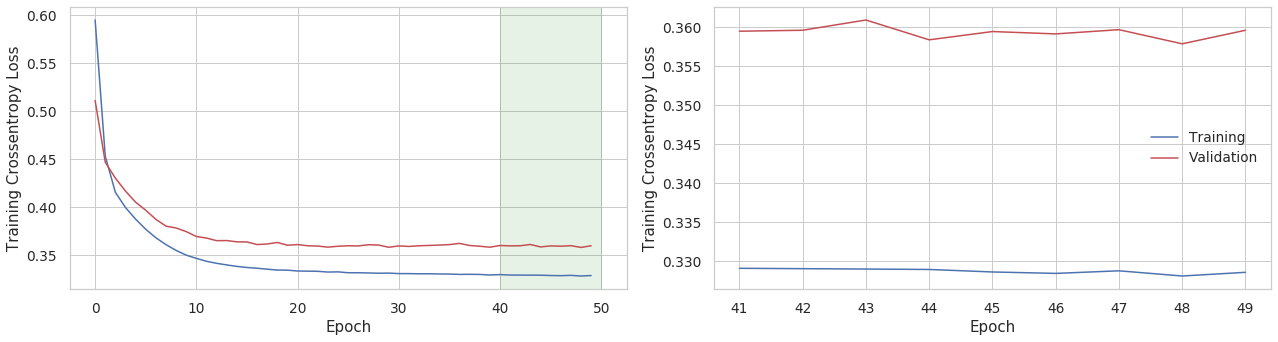

In [88]:
# Lineplot for the model Loss, with a hue to distinguish the Train set from the Validation set results
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale = 1.25)
fig, axs = plt.subplots(1, 2, figsize = (18, 5))

g = sns.lineplot(x = "Epoch", y = "Training Crossentropy Loss", color = "b", data = model_results_keras, ax = axs[0])
g = sns.lineplot(x = "Epoch", y = "Validation Crossentropy Loss", color = "r", data = model_results_keras, ax = axs[0])
g.axvspan(40, 50, color = 'green', alpha = 0.1)
sns.lineplot(x = "Epoch", y = "Training Crossentropy Loss", color = "b", data = model_results_keras_zoom, ax = axs[1])
sns.lineplot(x = "Epoch", y = "Validation Crossentropy Loss", color = "r", data = model_results_keras_zoom, ax = axs[1])

plt.tight_layout()
plt.legend(['Training', 'Validation'], loc = 'center right');

- Looking at the plot above on the left side, the model Loss ('binary_crossentropy') looks more stable after around 20 epochs. Even though these are just initial results with the "create_model" function default parameters, the trends look promising and also prone to get further optimization with hyperparameters tuning.
- The plot on the right side shows a zoomed section from the highlighted area in green at the plot from the left side. That shows the Validation loss (around 0.36) is quite close to the Training Loss (around 0.33), meaning the model is not overfitting in the Training process.

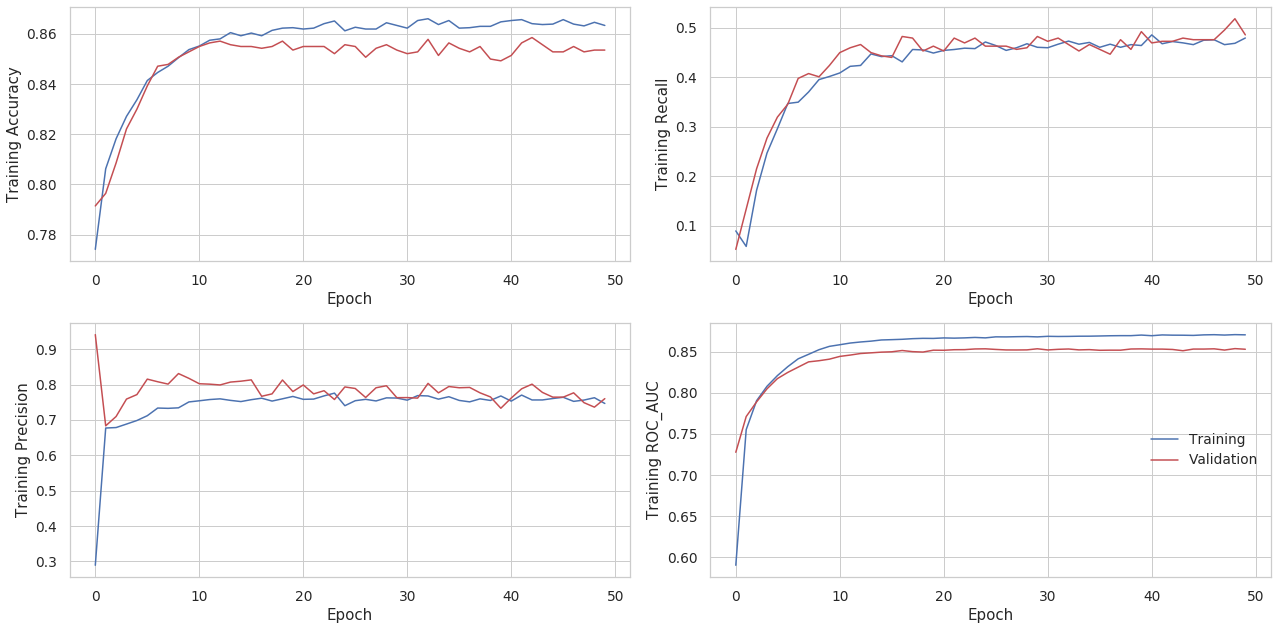

In [89]:
# Lineplot for all the other metrics, with a hue to distinguish the Train set from the Validation set results
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale = 1.25)
fig, axs = plt.subplots(2, 2, figsize = (18, 9))

g = sns.lineplot(x = "Epoch", y = "Training Accuracy", color = "b", data = model_results_keras, ax = axs[0,0])
g = sns.lineplot(x = "Epoch", y = "Validation Accuracy", color = "r", data = model_results_keras, ax = axs[0,0])

g = sns.lineplot(x = "Epoch", y = "Training Recall", color = "b", data = model_results_keras, ax = axs[0,1])
g = sns.lineplot(x = "Epoch", y = "Validation Recall", color = "r", data = model_results_keras, ax = axs[0,1])

g = sns.lineplot(x = "Epoch", y = "Training Precision", color = "b", data = model_results_keras, ax = axs[1,0])
g = sns.lineplot(x = "Epoch", y = "Validation Precision", color = "r", data = model_results_keras, ax = axs[1,0])

g = sns.lineplot(x = "Epoch", y = "Training ROC_AUC", color = "b", data = model_results_keras, ax = axs[1,1])
g = sns.lineplot(x = "Epoch", y = "Validation ROC_AUC", color = "r", data = model_results_keras, ax = axs[1,1])

plt.tight_layout()
plt.legend(['Training', 'Validation'], loc = 'center right');

- Looking at the plots above, that seems the Validation loss is quite close to the Training Loss for all the metrics (Accuracy, Recall, Precision and ROC_AUC Score), meaning the model is not overfitting in the Training process.

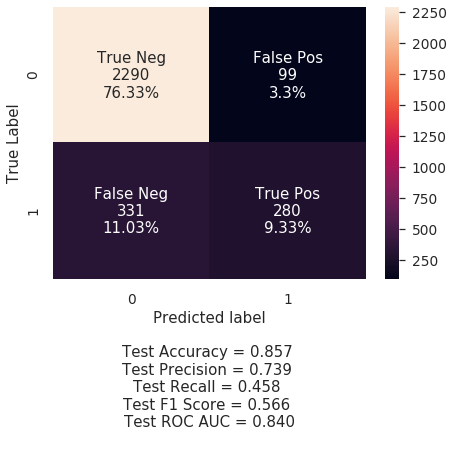

In [90]:
# Creating the Confusion Matrix for the inital Neural Network Classification model
make_confusion_matrix(initial_keras_model, y_test, threshold = 0.5, summary_metrics = True)

In [91]:
# Metrics for the inital Neural Network Classification model
# A function called "get_metrics_score_std_alone_keras" was previously created to extract the model scores from Keras' history 
keras_metrics_initial = get_metrics_score_std_alone_keras(model = initial_keras_model, history_dataframe = model_results_keras, flag = True)

Train Accuracy       = 0.863
Validation Accuracy  = 0.854
Test Accuracy        = 0.857

Train Recall         = 0.479
Validation Train     = 0.485
Test Recall          = 0.458

Train Precision      = 0.747
Validation Precision = 0.76
Test Precision       = 0.739

Train ROC_AUC        = 0.871
Validation ROC_AUC   = 0.853
Test ROC_AUC         = 0.84


- Results for the Neural Network Classifier without hyperparameters tuning:

  Test Accuracy = 0.857 | Test Recall = 0.458 | Test Precision = 0.739 | Test ROC_AUC Score = 0.84.
    
- Even though the test Accuracy is relatively high (0.857), the class imbalance for the target variable may turn the Accuracy a misleading metric (Accuracy Paradox).

- The test Recall (0.458) is not satisfatory for this initial model. Hyperparameters tuning and a modified threshold may improve the Recall for the Test set. This will be explored in the subsequent steps.

### 5.2 - Testing Various Models

- In order to understand how the initial Neural Network Classifier is compared to other Classifiers (Logistic Regression, Decision Trees and Ensemble), this session will cover the comparison for all these different Classification models.

- ROC_AUC Score was assigned as the metric of choice for all the Classification models, and it'll also be used in any model buildings upfront. Just in case, Recall and Precision will also be evaluated for all different models.

- To enable this comparison including several model, a Pipeline approach will be utilized. A 'StandardScaler' transformation is assigned to the Pipeline for all the models, including the one for the Neural Network Classifier. The 'StratifiedKFold' cross-validator will be used in all model buildings. This cross-validation object is a variation of KFold that returns stratified folds, or the folds are made by preserving the percentage of samples for each class in the training set. Also, the 'shuffle' argument will be set as 'True' in order to ensure each class' samples is shuffled before splitting into batches. A previously defined common seed ('random_state') will be used for all the 'StratifiedKFold' applications. Also, the number of folds will follow the previously defined number of 03 for all model buildings.

In [92]:
# Splitting the data into Train and Test sets
# This process is being done again since the data transformation will be automatically done inside the Pipelines
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = seed, stratify = y)
print(X_train.shape, X_test.shape)

(7000, 11) (3000, 11)


In [93]:
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7635,516,29,2,104982.57,1,1,0,157378.50,0,0,0
5284,745,51,3,99183.90,1,1,1,28922.25,1,0,1
1457,850,66,4,0.00,2,0,1,64350.80,0,0,1
4785,510,22,3,156834.34,1,0,0,44374.44,0,0,0
9158,540,31,10,118158.74,1,1,1,158027.57,0,1,0


- As seem on the Train set above, the data is no longer scaled. The scaling process will be carried out inside the Pipeline for all models.

In [94]:
# Building, fitting and appending the results for all Classification models with default parameters
models = []  # Empty list to store all the models

# Appending pipelines for each model into the list
models.append(("Logistic Regression", Pipeline([("scaler", StandardScaler()),
                                                ("linear_regression", LogisticRegression())])))

models.append(("Decision Tree      ", Pipeline([("scaler", StandardScaler()),
                                                ("decision_tree", DecisionTreeClassifier(random_state = seed))])))

models.append(("Random Forest      ", Pipeline([("scaler", StandardScaler()),
                                                ("random_forest", RandomForestClassifier(random_state = seed))])))

models.append(("Bagging Classifier ", Pipeline([("scaler", StandardScaler()),
                                                ("bagging", BaggingClassifier(random_state = seed))])))

models.append(("Gradient Boosting  ", Pipeline([("scaler", StandardScaler()),
                                                ("gradient_boosting", GradientBoostingClassifier(random_state = seed))])))

models.append(("Adaptive Boosting  ", Pipeline([("scaler", StandardScaler()),
                                                ("adaboost", AdaBoostClassifier(random_state = seed))])))

models.append(("XG Boost           ", Pipeline([("scaler", StandardScaler()),
                                                ("xgboost", XGBClassifier(eval_metric = "logloss", random_state = seed))])))

# Note that "validation_split = 0.2" is not used withe KerasClassifier because cross-validation is being used now
models.append(("Neural Network     ", Pipeline([("scaler", StandardScaler()),
                                                ("neural_network", KerasClassifier(build_fn = create_model, epochs = initial_epochs, verbose = False))])))

# Empty lists to store all model's CV scores
names = []
results_cv_train_ROC_AUC = []
results_test_ROC_AUC = []
results_cv_train_Recall = []
results_test_Recall = []
results_cv_train_Precision = []
results_test_Precision = []

# loop through all models to get the mean cross validated score
print()
print("Default Models Cross-validated Train Scores and Test Scores - ROC_AUC Score")
print()
for name, model in models:
    kfold = StratifiedKFold(n_splits = n_Folds, random_state = seed, shuffle = True)
    cv_result_ROC_AUC = cross_val_score(estimator = model, X = X_train, y = y_train, scoring = "roc_auc", cv = kfold)
    cv_result_Recall = cross_val_score(estimator = model, X = X_train, y = y_train, scoring = "recall", cv = kfold)
    cv_result_Precision = cross_val_score(estimator = model, X = X_train, y = y_train, scoring = "precision", cv = kfold)
    
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    test_result_ROC_AUC = round(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]), 3)
    test_result_Recall = round(recall_score(y_test, y_pred_test), 3)
    test_result_Precision = round(precision_score(y_test, y_pred_test), 3)
    
    results_cv_train_ROC_AUC.append(cv_result_ROC_AUC)
    results_test_ROC_AUC.append(test_result_ROC_AUC)
    results_cv_train_Recall.append(cv_result_Recall)
    results_test_Recall.append(test_result_Recall)
    results_cv_train_Precision.append(cv_result_Precision)
    results_test_Precision.append(test_result_Precision)
    names.append(name)
    print("{} - Average Train CV ROC_AUC  : {} | Test ROC_AUC  : {}".format(name, round(cv_result_ROC_AUC.mean(), 3), test_result_ROC_AUC))
    print("{} - Average Train CV Recall   : {} | Test Recall   : {}".format(name, round(cv_result_Recall.mean(), 3), test_result_Recall))
    print("{} - Average Train CV Precision: {} | Test Precision: {}".format(name, round(cv_result_Precision.mean(), 3), test_result_Precision))
    print()


Default Models Cross-validated Train Scores and Test Scores - ROC_AUC Score

Logistic Regression - Average Train CV ROC_AUC  : 0.762 | Test ROC_AUC  : 0.773
Logistic Regression - Average Train CV Recall   : 0.212 | Test Recall   : 0.2
Logistic Regression - Average Train CV Precision: 0.609 | Test Precision: 0.595

Decision Tree       - Average Train CV ROC_AUC  : 0.692 | Test ROC_AUC  : 0.675
Decision Tree       - Average Train CV Recall   : 0.52 | Test Recall   : 0.486
Decision Tree       - Average Train CV Precision: 0.494 | Test Precision: 0.476

Random Forest       - Average Train CV ROC_AUC  : 0.854 | Test ROC_AUC  : 0.839
Random Forest       - Average Train CV Recall   : 0.464 | Test Recall   : 0.452
Random Forest       - Average Train CV Precision: 0.752 | Test Precision: 0.769

Bagging Classifier  - Average Train CV ROC_AUC  : 0.817 | Test ROC_AUC  : 0.8
Bagging Classifier  - Average Train CV Recall   : 0.455 | Test Recall   : 0.435
Bagging Classifier  - Average Train CV Preci

In [95]:
# Compiling the Training set Cross Validation and Test set results for all Classification models

# ROC_AUC Score
results_cv_train_plot_ROC_AUC = pd.DataFrame(results_cv_train_ROC_AUC, index = names).reset_index().melt(id_vars = ['index'], value_name = 'ROC_AUC Score')
results_test_plot_ROC_AUC = pd.DataFrame(results_test_ROC_AUC, index = names, columns = ['ROC_AUC Score']).reset_index()

# Recall
results_cv_train_plot_Recall = pd.DataFrame(results_cv_train_Recall, index = names).reset_index().melt(id_vars = ['index'], value_name = 'Recall')
results_test_plot_Recall = pd.DataFrame(results_test_Recall, index = names, columns = ['Recall']).reset_index()

# Precision
results_cv_train_plot_Precision = pd.DataFrame(results_cv_train_Precision, index = names).reset_index().melt(id_vars = ['index'], value_name = 'Precision')
results_test_plot_Precision = pd.DataFrame(results_test_Precision, index = names, columns = ['Precision']).reset_index()

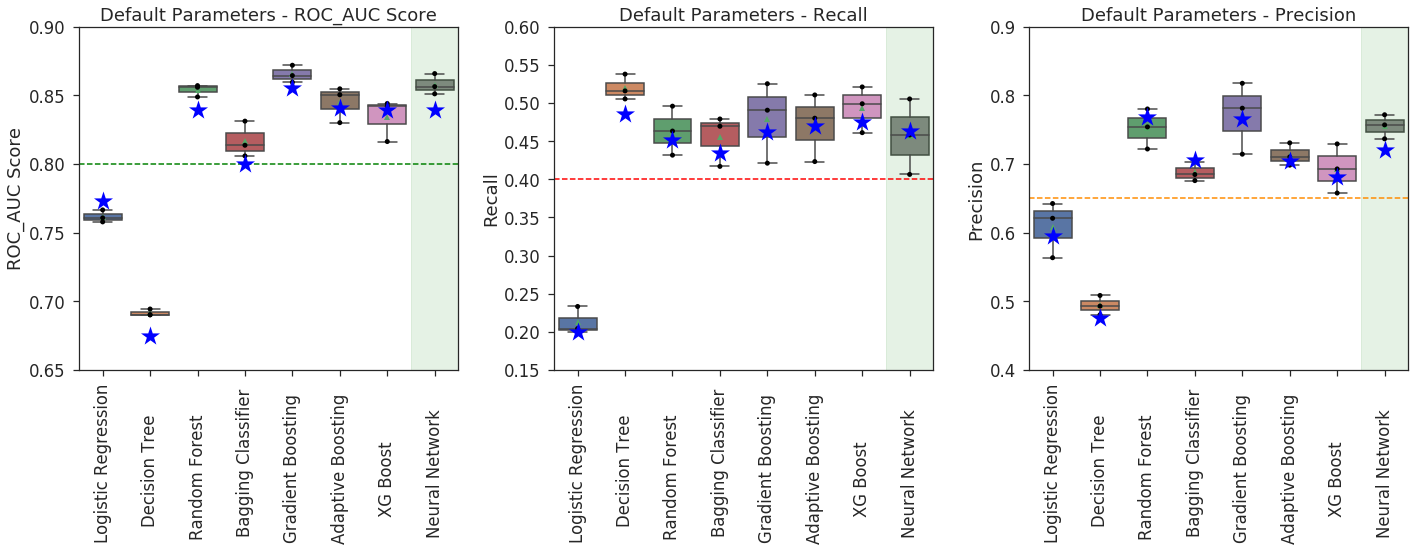

In [96]:
# Box Plots with the Summary for all Classfication models
# Points (black color) and Boxes represent the Cross-validated results on the Training Set
# Blue stars represent the Test Set Prediction for each model
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_context("notebook", font_scale = 1.5)
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

a = sns.boxplot(x = "index", y = "ROC_AUC Score", data = results_cv_train_plot_ROC_AUC, showmeans = True, ax = axs[0])
sns.stripplot(x = "index", y = "ROC_AUC Score", data = results_cv_train_plot_ROC_AUC, color = "black", jitter = False, ax = axs[0])
sns.stripplot(x = "index", y = "ROC_AUC Score", data = results_test_plot_ROC_AUC, size = 20,
              marker = '*', color = "blue", jitter = False, ax = axs[0]).set(title = "Default Parameters - ROC_AUC Score")
a.axhline(0.80, color = 'green', linestyle = '--')
a.axvspan(6.5, 7.5, color = 'green', alpha = 0.1)
a.set_ylim([0.65, 0.90])
a.set_xticklabels(a.get_xticklabels(), rotation = 90)
a.set(xlabel = None)

a = sns.boxplot(x = "index", y = "Recall", data = results_cv_train_plot_Recall, showmeans = True, ax = axs[1])
sns.stripplot(x = "index", y = "Recall", data = results_cv_train_plot_Recall, color = "black", jitter = False, ax = axs[1])
sns.stripplot(x = "index", y = "Recall", data = results_test_plot_Recall, size = 20,
              marker = '*', color = "blue", jitter = False, ax = axs[1]).set(title = "Default Parameters - Recall")
a.axhline(0.40, color = 'red', linestyle = '--')
a.axvspan(6.5, 7.5, color = 'green', alpha = 0.1)
a.set_ylim([0.15, 0.60])
a.set_xticklabels(a.get_xticklabels(), rotation = 90)
a.set(xlabel = None)

a = sns.boxplot(x = "index", y = "Precision", data = results_cv_train_plot_Precision, showmeans = True, ax = axs[2])
sns.stripplot(x = "index", y = "Precision", data = results_cv_train_plot_Precision, color = "black", jitter = False, ax = axs[2])
sns.stripplot(x = "index", y = "Precision", data = results_test_plot_Precision, size = 20,
              marker = '*', color = "blue", jitter = False, ax = axs[2]).set(title = "Default Parameters - Precision")
a.axhline(0.65, color = 'darkorange', linestyle = '--')
a.axvspan(6.5, 7.5, color = 'green', alpha = 0.1)
a.set_ylim([0.40, 0.90])
a.set_xticklabels(a.get_xticklabels(), rotation = 90)
a.set(xlabel = None)

plt.tight_layout();

- For the models above, a Pipeline with cross-validation was used for fitting. As expected, looking at the Neural Network Classifier, the ROC_AUC Score result was very close to the results from the previous model with a Validation set (Previous model Test ROC_AUC Score = 0.840 | Pipeline & CV Test ROC_AUC Score = 0.839). The same happened for the Recall (Previous model Test Recall = 0.458 | Pipeline & CV Test Recall = 0.463) and also for the Precision (Previous model Test Precision = 0.739 | Pipeline & CV Test Precision = 0.720).

- Regarding ROC_AUC Score (plot on the left), the worst performing models (with default parameters) were Logistic Regression and Decision Tree. For Recall (plot at the center), the worst performing model was Logistic Regression. For the Precision (plot on the right), the worst performing models were Logistic Regression and Decision Tree.

- Looking at the reference line on ROC_AUC plot (horizontal dash green line with ROC_AUC Score = 0.8), the Neural Network Classifier (with initial parameters) was comparable to the other Classifiers above the line (Random Forest, Bagging Classifier, Gradient Boosting, Adaptive Boosting and XG Boost). For the Recall, looking at the reference line (horizontal dash red line with Recall = 0.4), the Neural Network Classifier (with initial parameters) was comparable to the other Classifiers above the line (Decision Tree, Random Forest, Bagging Classifier, Gradient Boosting, Adaptive Boosting and XG Boost). For the Precision, looking at the reference line (horizontal dash orange line with Precision = 0.65), the Neural Network Classifier (with initial parameters) was also comparable to the other Classifiers above the line (Random Forest, Bagging Classifier, Gradient Boosting, Adaptive Boosting and XG Boost).

- With these initial results and comparison with other models, the Neural Network Classifier looks very promissing. Some additional improvements in performance can be potentially achieved with hyperparameters tuning and also by adjusting the threshold. This will be covered in the next sessions.

### 5.3 - Initial Neural Network Classifier (Pipeline Model)

In [97]:
# Create Model Pipeline with the 'StandardScaler' transformation and a Scikit-Learn wrapper with a Keras Model ("create_model" function)
NN_pipeline_initial = Pipeline(steps = [("scaler", StandardScaler()), ("neural_network", KerasClassifier(build_fn = create_model,
                                                                                                         epochs = initial_epochs, verbose = False))])

In [98]:
# Fitting the Model
NN_pipeline_initial_fit = NN_pipeline_initial.fit(X_train, y_train)

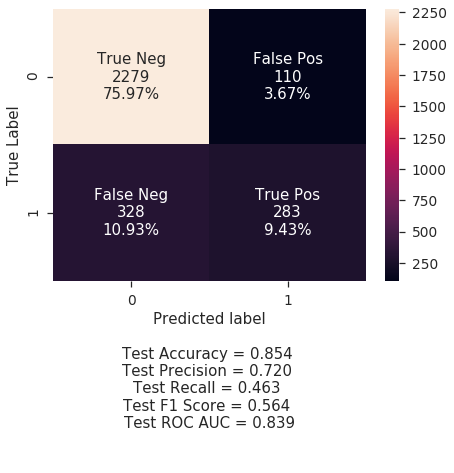

In [99]:
# Creating the Confusion Matrix for the inital Neural Network Classification model
make_confusion_matrix(NN_pipeline_initial, y_test, threshold = 0.5, summary_metrics = True)

In [100]:
# Metrics for the Initial Neural Network Classification model
# A function called "get_metrics_score" was previously created to extract the model scores from Pipeline model
keras_initial = get_metrics_score(model = NN_pipeline_initial, n_splits = n_Folds, seed_splits = seed, flag = True)

Average Train Accuracy  = 0.859
Test Accuracy           = 0.854
Average Train Recall    = 0.457
Test Recall             = 0.463
Average Train Precision = 0.755
Test Precision          = 0.72
Average Train F1 Score  = 0.568
Test F1 Score           = 0.564
Train ROC AUC Score     = 0.858
Test ROC AUC Score      = 0.839


- This initial Neural Network Classifier will be used at the next session to compare with other models including tuning and change in the threshold.

***
## 6. Model Performance Improvement<a class="anchor" id="6666"></a>

<span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:blue;">
    
- Comment on which metric is right for model performance evaluation and why? (covered at session 4.4 - Classification Models Evaluation Criteria)
- Find the optimal threshold using ROC-AUC or Precision-Recall curves
- Comment on model performance - Can model performance be improved? (covered at session 5.2 - Testing Various Models)
- Build another model to implement these improvements 
- Include all the model which were trained to reach at the final one

### 6.1 - Neural Network Classification Model Hyperparameters Tuning

- Several hyperparameters are included in the tuning process: optimizer, initializer, number of epochs, batch size, learning rate, momentum, activation function, dropout rate, class weight, number of neurons on the 1st hidden layer, numer of neurons on the 2nd hidden layer and number of nuerons on the 3rs hidden layer.

- One of the hyperparameters is the "class_weight" and it allows to create a dictionary that maps class integer values to the importance to apply to each class on the dependent variable. There's a relevant class imbalance on the 'Exited' categories, with 79.63% of data associated with '0' (existing Customer) and 20.37% of the data associated with '1' (attrited Customer)'. A best practice for using the class weighting is to use the inverse of the class distribution present in the training dataset, in this case rounded to {0:20, 1:80}. With the inclusion of the "class_weight" hyperparameter, it's expected the tuning process will converge to a better AUC-ROC Score which is inherently more robust from the Dependent variable classes imbalance.

- A Ramdomized Search Cross Validation ('RandomizedSearchCV') approach is utilized to perform the tuning for the model hyperparameters inclusing 150 tuning iterations. A Pipeline containing a 'StandardScaler' transformation and a Scikit-Learn wrapper with a Keras Model in included within the Ramdomized Search Cross Validation process.

In [ ]:
# Start Counting the Running Time
tic = time()

# Create Model Pipeline with the 'StandardScaler' transformation and a Scikit-Learn wrapper with a Keras Model ("create_model" function)
NN_pipeline_tuning = Pipeline(steps = [("scaler", StandardScaler()), ("neural_network", KerasClassifier(build_fn = create_model, verbose = False))])

# Dictionary with all Hyperparameters included in Ramdomized Search process
parameters = {'neural_network__optimizer' : ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'],
              'neural_network__init' : ['glorot_uniform', 'normal', 'uniform', 'he_normal'],
              'neural_network__epochs' : [25, 50, 100, 150, 200],
              'neural_network__batch_size' : [5, 8, 16, 32, 64, 128],
              'neural_network__learn_rate' : [0.0005, 0.001, 0.01, 0.05, 0.1, 0.2],
              'neural_network__momentum' : [0.0, 0.2, 0.4, 0.6, 0.8, 0.9],
              'neural_network__activation' : ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'],
              'neural_network__dropout_rate' : [0.0, 0.1, 0.2, 0.3],
              'neural_network__class_weight' : [None, {0:20, 1:80}],
              'neural_network__neurons_1st' : [22, 44],
              'neural_network__neurons_2nd' : [11, 22],
              'neural_network__neurons_3rd' : [5, 11]}

# Scoring metric definition (ROC_AUC Score)
scorer = 'roc_auc'

# Calling RandomizedSearchCV
grid_cv = RandomizedSearchCV(estimator = NN_pipeline_tuning, param_distributions = parameters, scoring = scorer, n_iter = random_search_samples,
                       cv = StratifiedKFold(n_splits = n_Folds, shuffle = True, random_state = seed) , random_state = seed, n_jobs = -1, verbose = True)

# Fitting the Models
grid_result = grid_cv.fit(X_train, y_train)

# Setting the best selected Neural Network Classification model (best combination of hypeparameters)
keras_model_tuning_result = grid_cv.best_estimator_

# Test set predictions for the best selected Classification model (ROC_AUC Score)
test_score_tuning = round(roc_auc_score(y_test, keras_model_tuning_result.predict_proba(X_test)[:, 1]), 3)

# Test set predictions for the best selected Classification model (Recall and Precision)
y_pred_test_tuning = keras_model_tuning_result.predict(X_test)
test_recall = round(recall_score(y_test, y_pred_test_tuning), 3)
test_precision = round(precision_score(y_test, y_pred_test_tuning), 3)

# Train set Cross Validation average prediction for the best selected Classification model (ROC_AUC Score)
CV_mean = grid_result.cv_results_['mean_test_score']
CV_std_dev = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(CV_mean, CV_std_dev, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print()
print("Best Parameters:{} \nTrain ROC-AUC CV Score: {} \nTest ROC-AUC: {} | Test Recall: {} | Test Precision: {}".format(grid_cv.best_params_,
                                                                                                                         round(grid_cv.best_score_, 3),
                                                                                                                         test_score_tuning,
                                                                                                                         test_recall,test_precision))
print()

# Time in seconds taken to complete the hyperparameters tuning process
keras_model_time = time() - tic
print("done in {:.3f}s".format(keras_model_time))

In [102]:
# Creating a dataframe with all the 150 Ramdomized Search iteration and sorting it by rank test score
# 1st model in the dataframe is ranked #1 or the best Classification model for the defined scoring metric (ROC_AUC Score)
scores_keras_model_tuning = pd.DataFrame(grid_result.cv_results_)
scores_keras_model_tuning = scores_keras_model_tuning.sort_values(by = ['rank_test_score']).reset_index(drop = 'index')
scores_keras_model_tuning.T

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
mean_fit_time,133.364335,55.312985,58.270548,192.479954,66.46905,550.903654,24.130885,1101.478323,15.187477,61.629023,...,551.186317,510.397026,249.233787,39.06624,171.462119,134.787851,62.972119,504.521324,18.824081,113.590036
std_fit_time,11.581875,1.247023,0.509731,3.769593,12.122403,18.617318,1.050126,4.870925,6.061468,0.194646,...,9.588961,3.974343,21.15669,6.294502,22.235401,4.547264,0.988111,0.514102,0.956961,1.601409
mean_score_time,0.401652,0.574935,0.308796,0.329347,0.414234,1.326709,0.470172,0.800349,0.364476,0.637722,...,0.588412,1.579539,1.073985,0.470475,1.300308,0.500629,0.772201,1.669107,0.345188,0.707418
std_score_time,0.049616,0.075264,0.022301,0.020235,0.07433,0.09782,0.083525,0.081954,0.094568,0.163439,...,0.07565,0.132303,0.550152,0.08784,0.528126,0.060901,0.306252,0.277228,0.030628,0.187521
param_neural_network__optimizer,SGD,RMSprop,Nadam,Nadam,SGD,SGD,Adamax,Nadam,Adamax,Adagrad,...,Adam,Nadam,Adamax,SGD,Nadam,RMSprop,SGD,Adam,Adadelta,SGD
param_neural_network__neurons_3rd,11,11,5,5,11,11,11,11,11,5,...,5,11,5,11,11,5,11,11,11,5
param_neural_network__neurons_2nd,22,22,11,11,11,11,11,11,11,11,...,11,22,22,11,11,22,11,22,11,11
param_neural_network__neurons_1st,22,22,22,44,44,22,22,44,44,44,...,44,22,22,22,44,22,44,44,44,22
param_neural_network__momentum,0.9,0.6,0.6,0.2,0.6,0.6,0.8,0.9,0.9,0.6,...,0.0,0.6,0.9,0.8,0.0,0.6,0.9,0.6,0.8,0.2
param_neural_network__learn_rate,0.01,0.01,0.001,0.001,0.01,0.2,0.05,0.01,0.1,0.2,...,0.05,0.1,0.1,0.2,0.1,0.1,0.2,0.2,0.0005,0.0005


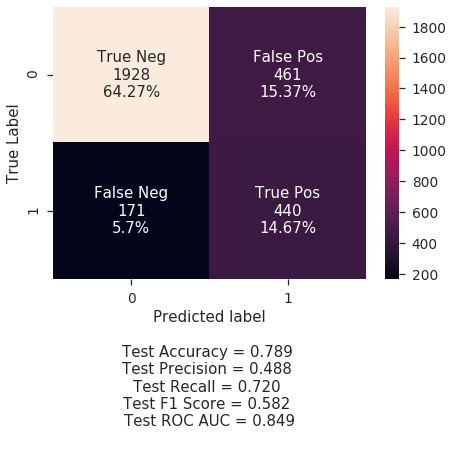

In [103]:
# Creating the Confusion Matrix for the tuned Neural Network Classification model
make_confusion_matrix(keras_model_tuning_result, y_test, threshold = 0.5, summary_metrics = True)

In [104]:
# Metrics for the tuned Neural Network Classification model
# A function called "get_metrics_score" was previously created to extract the model scores from Pipeline model
keras_tuned_model_metrics = get_metrics_score(model = keras_model_tuning_result, n_splits = n_Folds, seed_splits = seed, flag = True)

Average Train Accuracy  = 0.81
Test Accuracy           = 0.789
Average Train Recall    = 0.726
Test Recall             = 0.72
Average Train Precision = 0.525
Test Precision          = 0.488
Average Train F1 Score  = 0.609
Test F1 Score           = 0.582
Train ROC AUC Score     = 0.863
Test ROC AUC Score      = 0.849


- Results for the Neural Network Classifier with Hyperparameters tuning:

    Average Cross-validated Train ROC-AUC Score = 0.863 | Test ROC-AUC Score = 0.849\
    Average Cross-validated Train Recall        = 0.726 | Test Recall        = 0.72\
    Average Cross-validated Train Precision     = 0.525 | Test Precision     = 0.488
    
- The ROC_AUC Score and Recall Test results for the Neural Network Classifier with tuning are better than the results without tuning. The ROC_AUC Score had an improvement of 1% and the Recall had an improvement of 56%. The Precision for the tuned model was degraded in 32%. The Recall improved in a higher percentage than the Precision was degraded.

- Now with a tuned model for the ROC_AUC Score, an additional improvement for the Recall can be achieved by exploring a threshold change.

### 6.2 - Neural Network Classification Model with Hyperparameters Tuning and Threshold Change

- The Test Recall for the best selected (tuned) model is 0.72. As mentioned before, a new threshold can now be explored in order to get an additional improvement on Recall.

- Here it's assumed that a Target Recall of 0.8 would be more adequate for the business. With that, it's expected to increase the amount of true positives and/or reduce the amount of false negatives, reducing the likelihood to misclassify exited/attrited Customers as existing Customers.

In [105]:
# Obtaining the ROC_AUC Score and the AUC-ROC Curve information from the tuned Classifier
NN_tuned_roc_auc_score = roc_auc_score(y_test, keras_model_tuning_result.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, keras_model_tuning_result.predict_proba(X_test)[:,1])

In [106]:
# Creating a dataframe with the information coming from the ROC Curve (tuned model)
ROC_data_tuned_model = pd.DataFrame()
ROC_data_tuned_model['True Positive Rate (Recall or Sensitivity)'] = tpr
ROC_data_tuned_model['False Positive Rate (1 - Specificity)'] = fpr
ROC_data_tuned_model['Thresholds'] = thresholds
ROC_data_tuned_model.head()

,True Positive Rate (Recall or Sensitivity),False Positive Rate (1 - Specificity),Thresholds
0,0.000000,0.000000,1.999173
1,0.036007,0.000000,0.999173
2,0.086743,0.000000,0.978123
3,0.086743,0.000419,0.975550
4,0.144026,0.000419,0.945690


In [107]:
# New Threshold calculation to get an additional improvement on Recall
# Using a Target Recall of 0.8
target_recall = 0.80
average_ROC_tuned_model = ROC_data_tuned_model[(round(ROC_data_tuned_model['True Positive Rate (Recall or Sensitivity)'], 2) == target_recall)].mean()
print("For a Target Recall of {}, the new Threshold should be around {}".format(target_recall, round(average_ROC_tuned_model.iloc[2], 4)))

For a Target Recall of 0.8, the new Threshold should be around 0.3974


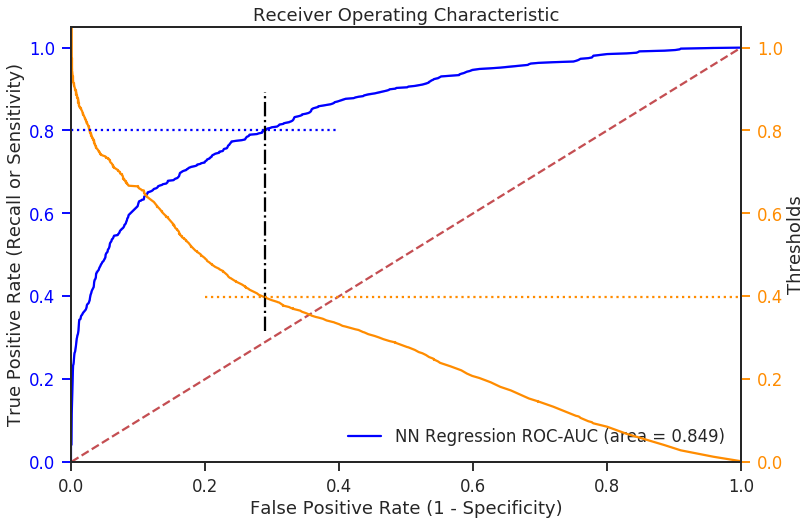

In [108]:
# Plotting the AUC-ROC Curve
sns.set({'figure.figsize': (12, 8)})
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_context("talk")
sns.lineplot(x = "False Positive Rate (1 - Specificity)", y = "True Positive Rate (Recall or Sensitivity)", color = "blue", data = ROC_data_tuned_model,
             label = 'NN Regression ROC-AUC (area = {0:.3f})'.format(NN_tuned_roc_auc_score))
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right', borderpad = 0.5)
plt.tick_params(axis='y', colors='blue')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
ax2 = plt.twinx()
sns.lineplot(x = "False Positive Rate (1 - Specificity)", y = "Thresholds", color = "darkorange", err_style = "bars", data = ROC_data_tuned_model, ax = ax2)

# Target Recall 
plt.axhline(average_ROC_tuned_model['True Positive Rate (Recall or Sensitivity)'], xmin = 0, xmax = 0.4, ls=':', color = 'blue')
plt.axvline(average_ROC_tuned_model['False Positive Rate (1 - Specificity)'], ymin = 0.3, ymax = 0.85, ls='-.', color = 'black')
plt.axhline(average_ROC_tuned_model['Thresholds'], xmin = 0.2, xmax = 1, ls=':', color = 'darkorange')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tick_params(axis='y', colors = 'darkorange');

- The blue horizontal dotted line on the plot above represents the Target Recall of 0.8.
    
- The black dash-dotted vertical line was used to bring the reference of the Target Recall from the AUC-ROC Curve (solid blue) to the Threshold curve (solid orange).
    
- A Threshold of 0.4 was calculated based on the intersection of the black dash-dotted line to the Threshold curve (solid orange). The dotted orange line represents the new Threshold value.
    
- Just in case, a Precision-Recall Curve will be also constructed as the next step.

In [109]:
# Obtaining the Precision-Recall Curve information from the tuned Classifier
NN_precision, NN_recall, NN_thresholdsPR = precision_recall_curve(y_test, keras_model_tuning_result.predict_proba(X_test)[:,1])

In [110]:
# Creating a dataframe with the information coming from the Precision-Recall Curve (tuned model)
# Last Precision and the Recall values should be ignored
# The last Precision and Recall values are always 1. and 0. respectively and do not have a corresponding threshold.
PR_data_tuned_model = pd.DataFrame()
PR_data_tuned_model['Precision'] = NN_precision[:-1]
PR_data_tuned_model['True Positive Rate (Recall or Sensitivity)'] = NN_recall[:-1]
PR_data_tuned_model['Thresholds'] = NN_thresholdsPR

In [111]:
# New Threshold calculation to Maximize the Recall
# Note that here's being assumed a target Recall of 0.9
average_PR_tuned_model = PR_data_tuned_model[(round(PR_data_tuned_model['True Positive Rate (Recall or Sensitivity)'], 2) == target_recall)].mean()
print("For a Target Recall of {}, the new Threshold should be around {}".format(target_recall, round(average_PR_tuned_model.iloc[2], 4)))

For a Target Recall of 0.8, the new Threshold should be around 0.3975


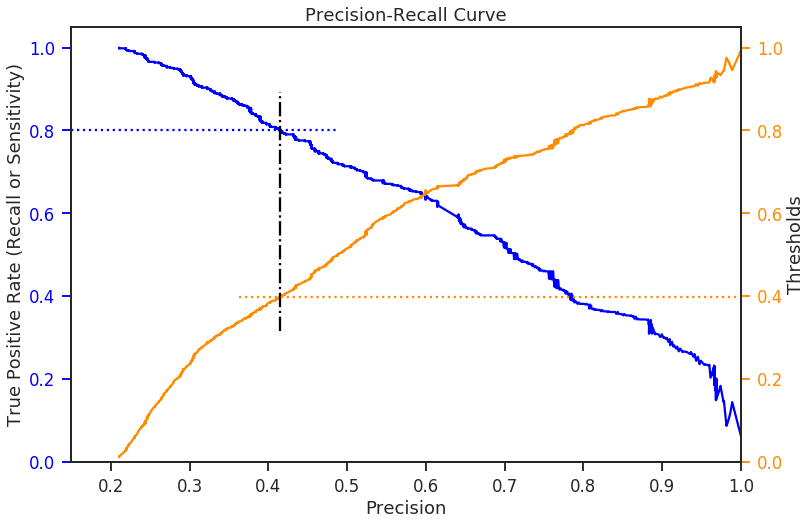

In [112]:
# Precision-Recall Curve
sns.set({'figure.figsize': (12, 8)})
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_context("talk")
sns.lineplot(x = "Precision", y = "True Positive Rate (Recall or Sensitivity)", color = "blue", data = PR_data_tuned_model)
plt.title('Precision-Recall Curve')
plt.tick_params(axis='y', colors='blue')
plt.xlim([0.15, 1.0])
plt.ylim([0.0, 1.05])
ax2 = plt.twinx()
sns.lineplot(x = "Precision", y = "Thresholds", color = "darkorange", err_style = "bars", data = PR_data_tuned_model)

# Target Recall 
plt.axhline(average_PR_tuned_model['True Positive Rate (Recall or Sensitivity)'], xmin = 0, xmax = 0.4, ls=':', color = 'blue')
plt.axvline(average_PR_tuned_model['Precision'], ymin = 0.3, ymax = 0.85, ls='-.', color = 'black')
plt.axhline(average_PR_tuned_model['Thresholds'], xmin = 0.25, xmax = 1, ls=':', color = 'darkorange')

plt.xlim([0.15, 1.0])
plt.ylim([0.0, 1.05])
plt.tick_params(axis='y', colors = 'darkorange');

- The blue horizontal dotted line on the plot above represents the Target Recall of 0.8.
    
- The black dash-dotted vertical line was used to bring the reference of the Target Recall from the Precision-Recall Curve (solid blue) to the Threshold curve (solid orange).
    
- A Threshold of 0.4 was calculated based on the intesection of the black dash-dotted line to the Threshold curve (solid orange). The dotted orange line represents the new Threshold value.
    
- This new threshold will be utilized to reach the Target Recall on the Classification model.

In [113]:
# Defining the new Threshold to reach the Target Recall
new_threshold = 0.4

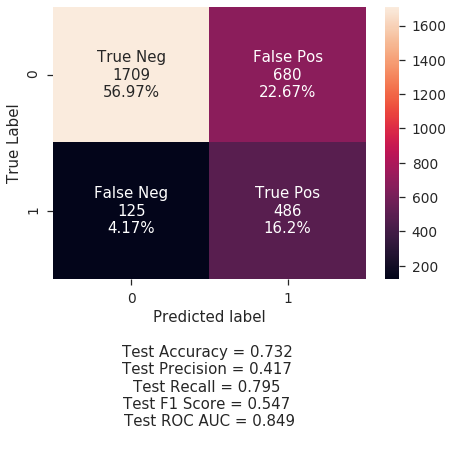

In [114]:
# Creating the Confusion Matrix for the tuned Neural Network Classification model with the new Threshold
make_confusion_matrix(keras_model_tuning_result, y_test, threshold = 0.4, summary_metrics = True)

- As expected, the threshold calculation using both AUC-ROC and Precision-Recall Curves got same results (0.4).

- Looking at the Confusion Matrix above, the new thershold of 0.4 enabled to obtain a Recall of 0.795.

***
## 7. Model Performance Evaluation<a class="anchor" id="7777"></a>

<span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:blue;">
    
- Evaluate the model on different performance metrics and comment on the performance and scope of improvement

### 7.1 - Comparing all the Neural Network Classification Models

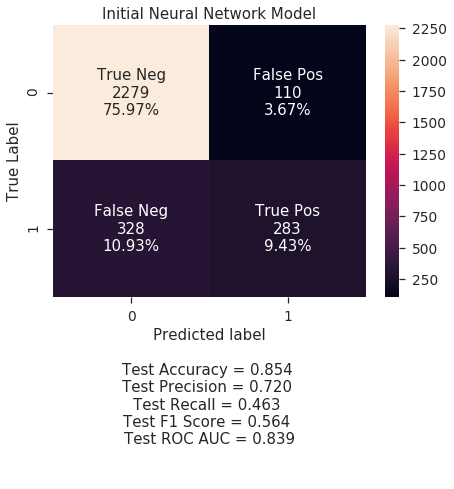

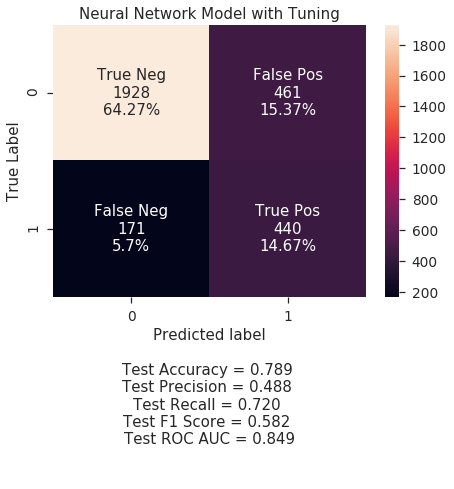

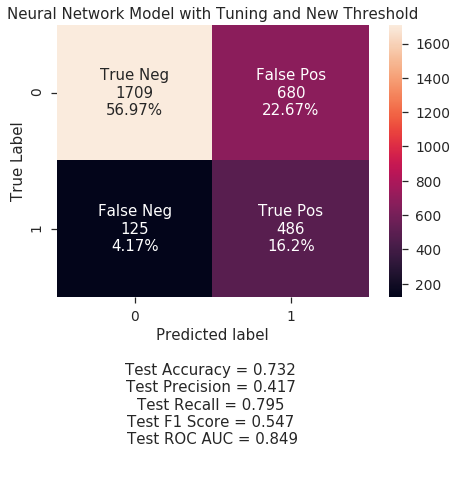

In [115]:
# Comparing all the Neural Network Classifiers

# Initial Neural Network model (initial parameters / no tuning)
make_confusion_matrix(NN_pipeline_initial, y_test, threshold = 0.5, plot_title = "Initial Neural Network Model")

# Neural Network model with Hyperparameters Tuning
make_confusion_matrix(keras_model_tuning_result, y_test, threshold = 0.5, plot_title = "Neural Network Model with Tuning")

# Neural Network model with Hyperparameters Tuning and new Threshold
make_confusion_matrix(keras_model_tuning_result, y_test, threshold = 0.4, plot_title = "Neural Network Model with Tuning and New Threshold")

- Initial Neural Network model (initial parameters / no tuning): Test Accuracy = 0.854 | Test Recall = 0.463 | Test Precision = 0.720 | Test ROC_AUC Score = 0.839.

- Neural Network model with Hyperparameters Tuning: Test Accuracy = 0.789 | Test Recall = 0.720 | Test Precision = 0.488 | Test ROC_AUC Score = 0.849.

- Neural Network model with Hyperparameters Tuning and new Threshold: Test Accuracy = 0.732 | Test Recall = 0.795 | Test Precision = 0.417 | Test ROC_AUC Score = 0.849. A remark here is that that the ROC_AUC Score is not affected by the change in the threshold.

- By changing the Threshold from 0.5 to 0.4, the Test Recall settles at the Target Recall (0.795). With the new Threshold of 0.4 the Test Precision is degraded from 0.488 to 0.417 - this is deemed as acceptable since the Recall is more important than precision for the context of the business. Lower Precision would be translated as the Customers not leaving the bank services but the model predicted them to exit/leave - this is not as harmfull to the business as a lower Recall could be.

### 7.2 - Final Classification Model Explain-ability - Variables Importance

- ELI5 is a Python library which allows to visualize and debug various Machine Learning models using unified API. It has built-in support for several ML frameworks and provides a way to explain black-box models. It provides a way to compute feature importances for any black-box estimator by measuring how score decreases when a feature is not available; the method is also known as “permutation importance” or “Mean Decrease Accuracy (MDA)”.

- ELI5 library will be utilized to estimate the variables importance for the final Classification model.

In [116]:
# Calculation the model Permutations Importance
perm = PermutationImportance(keras_model_tuning_result, random_state = seed).fit(X_train, y_train)

In [117]:
# Returning the Weights for the variables in the model (based on Permutation Importances)
eli5.show_weights(perm, feature_names = X.columns.tolist())

Weight,Feature
0.1027 ± 0.0050,NumOfProducts
0.0831 ± 0.0019,Age
0.0289 ± 0.0064,IsActiveMember
0.0231 ± 0.0049,Balance
0.0227 ± 0.0024,Geography_Germany
0.0074 ± 0.0029,Gender_Male
0.0037 ± 0.0022,CreditScore
0.0032 ± 0.0015,HasCrCard
0.0030 ± 0.0012,EstimatedSalary
0.0030 ± 0.0016,Tenure


- Looking at the table above, the top 06 variables in terms on importance for the Classification model are: NumOfProducts, Age, Geography_Germany, IsActiveMember, Balance and Gender. This is matching with the outcomes from the EDA session.

### 7.3 - Final Classification Model Explain-ability - Relations between Predictors and Model Outcome

- PDPbox is a Python library which allows to Visualize the impact of certain features towards model prediction for any supervised learning algorithm using Partial Dependence Plots.

- PDPbox library will be utilized to better understand the relations between the features and the response varibale for the final Classification model.

In [118]:
# Common settings for PDP Plots
ylim_start = 0.00
ylim_end = 1
figsize = (12, 5)
model_plots = keras_model_tuning_result

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
posx and posy should be finite values


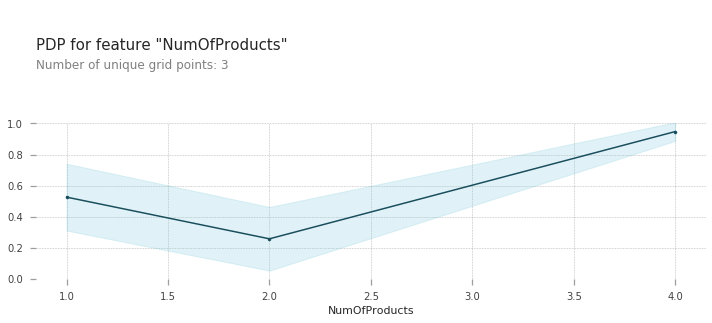

posx and posy should be finite values
posx and posy should be finite values


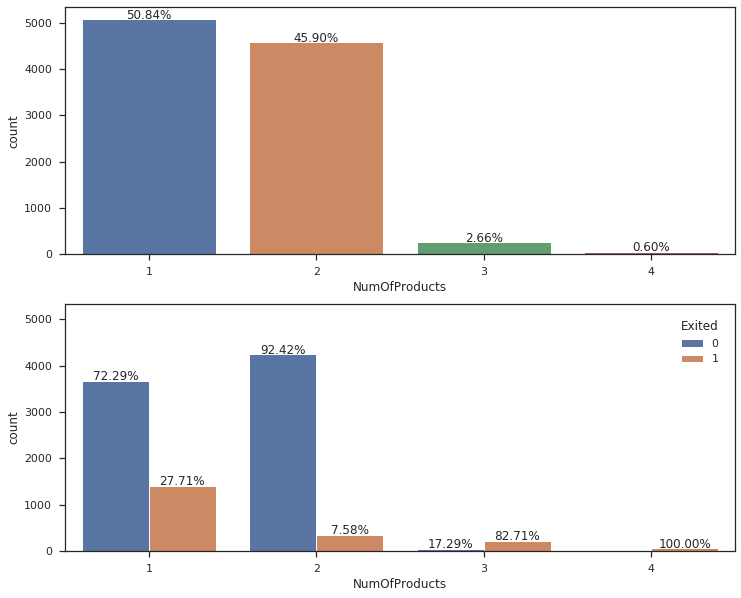

In [119]:
# PDP Plot (Isolation Plot) for 'NumOfProducts' vs. 'Exited'
pdp_goals = pdp.pdp_isolate(model = model_plots, dataset = X_train, model_features = X_train.columns, feature = 'NumOfProducts')
pdp.pdp_plot(pdp_isolate_out = pdp_goals, feature_name = 'NumOfProducts', center = False, figsize = figsize)
plt.ylim(ylim_start, ylim_end)

# Plot created at the EDA session for 'NumOfProducts'
percentage_on_bar(feature = "NumOfProducts", hue = "Exited", data = data, order = None, hue_order = None, size = (12, 10))

- Looking at the Isolation Plot for 'NumberOfProducts', Customers who have 02 products (accounts or other bank account affiliated products) are less likely to exit the bank services.

- This behavior is matching what was previously visualized ate the EDA session - see barplot above (orange vs. blue bars at the bottom plot). Category '2' for 'NumberOfProducts' takes a lower percentage of Customer attrition than other categories.

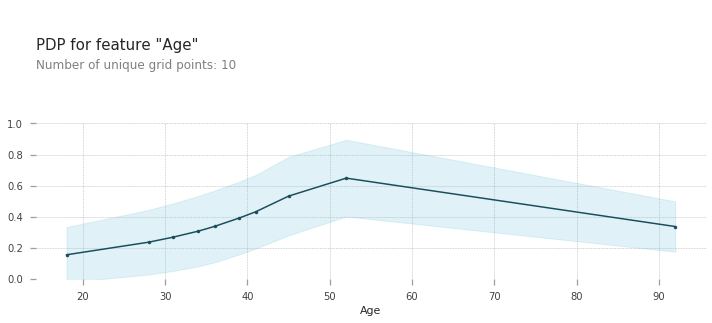

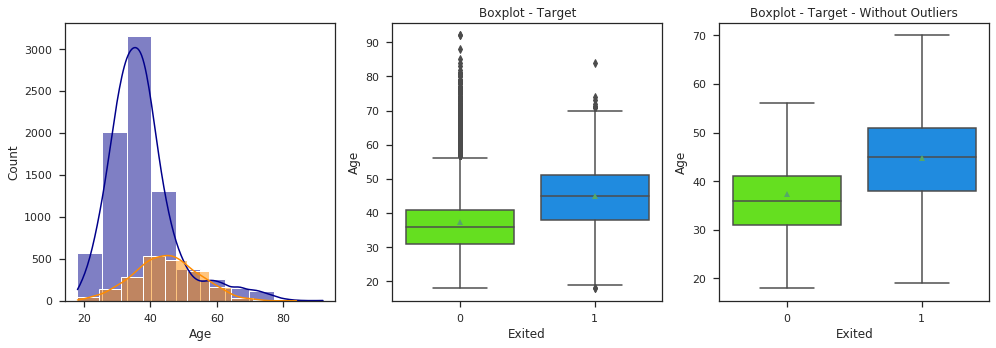

In [120]:
# PDP Plot (Isolation Plot) for 'Age' vs. 'Exited'
pdp_goals = pdp.pdp_isolate(model = model_plots, dataset = X_train, model_features = X_train.columns, feature = 'Age')
pdp.pdp_plot(pdp_isolate_out = pdp_goals, feature_name = 'Age', center = False, figsize = figsize)
plt.ylim(ylim_start, ylim_end)

# Plot created at the EDA session for 'Age'
combo_plot(feature = 'Age', target = 'Exited', data = df, nbins = 10)

- Looking at the Isolation Plot for 'Age', either younger (less than 30 yrs. old) or older (more than 80 yrs. old) Customers are less likely to leave the bank services. Customer between 45 and 60 yrs. old are more likely to exit the bank services.

- Because the 'Age' is a Numerical/Discrete variable with several categories and due to its non-linear relationship with 'Exited', this behavior was partially captured at the EDA session.

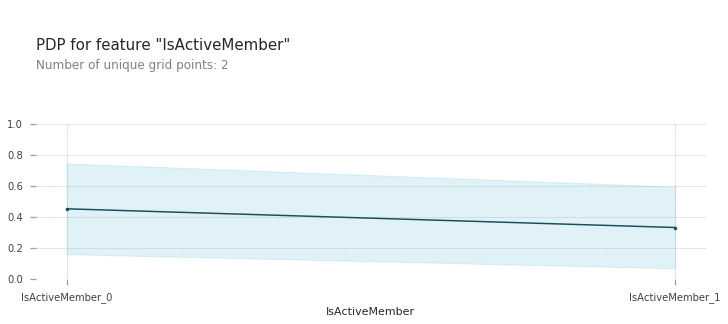

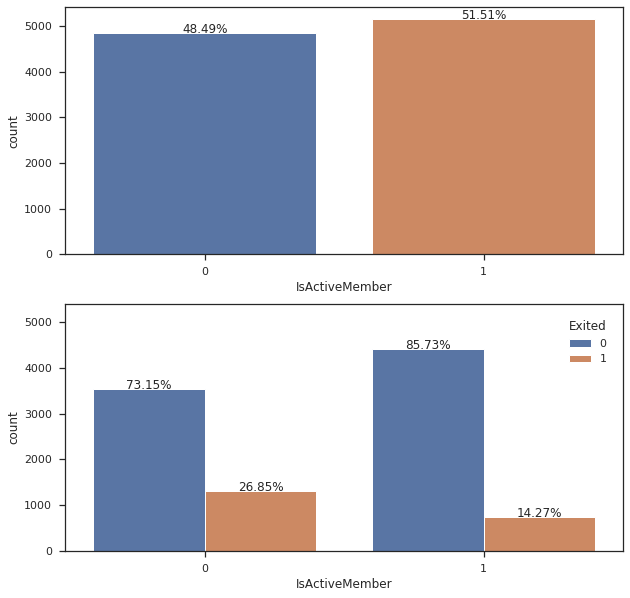

In [121]:
# PDP Plot (Isolation Plot) for 'IsActiveMember' vs. 'Exited'
pdp_goals = pdp.pdp_isolate(model = model_plots, dataset = X_train, model_features = X_train.columns, feature = 'IsActiveMember')
pdp.pdp_plot(pdp_isolate_out = pdp_goals, feature_name = 'IsActiveMember', center = False, figsize = figsize)
plt.ylim(ylim_start, ylim_end)

# Plot created at the EDA session for 'IsActiveMember'
percentage_on_bar(feature = "IsActiveMember", hue = "Exited", data = df, order = None, hue_order = None, size = (10, 10))

- Looking at the Isolation Plot for 'IsActiveMember', Customers who are not actively using the bank services ('IsActiveMember' at '0') are more likely to exit.

- This behavior is matching what was previously visualized at the EDA session - see barplot above (orange vs. blue bars at the bottom plot). Category '0' for 'IsActiveMember' takes a higher percentage of Customer attrition.

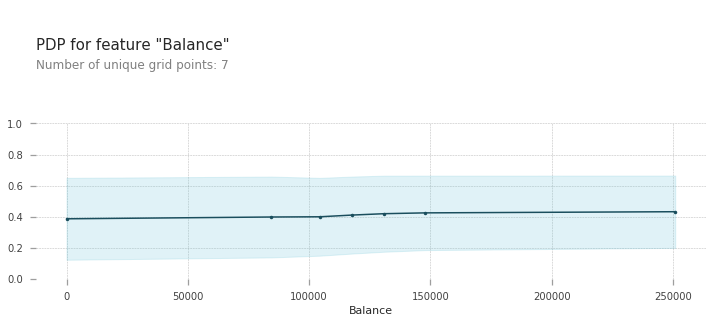

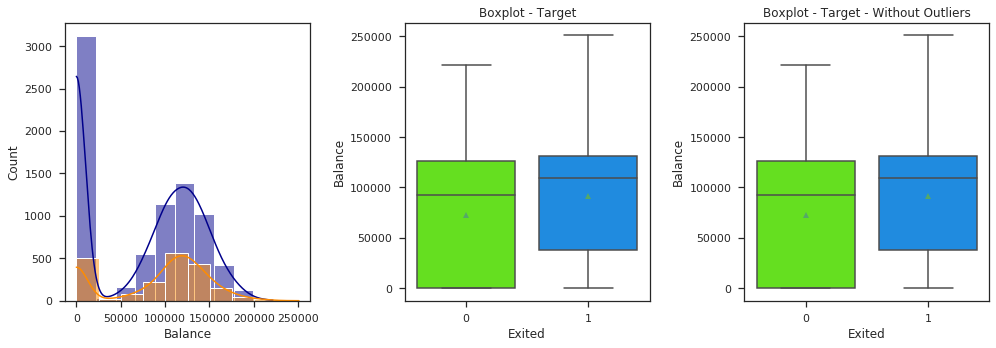

In [122]:
# PDP Plot (Isolation Plot) for 'Balance' vs. 'Exited'
pdp_goals = pdp.pdp_isolate(model = model_plots, dataset = X_train, model_features = X_train.columns, feature = 'Balance')
pdp.pdp_plot(pdp_isolate_out = pdp_goals, feature_name = 'Balance', center = False, figsize = figsize)
plt.ylim(ylim_start, ylim_end)

# Plot created at the EDA session for 'Balance'
combo_plot(feature = 'Balance', target = 'Exited', data = df, nbins = 10)

- Looking at the Isolation Plot for 'Balance', Customers with more balance (more money deposited in their bank accounts) are more likely to exit the bank services.

- This behavior is matching what was previously visualized ate the EDA session - see boxplots above (green box vs. blue box at the bottom plot). Category '1' for 'Balance' shows a slightly higher average of Customer attrition.

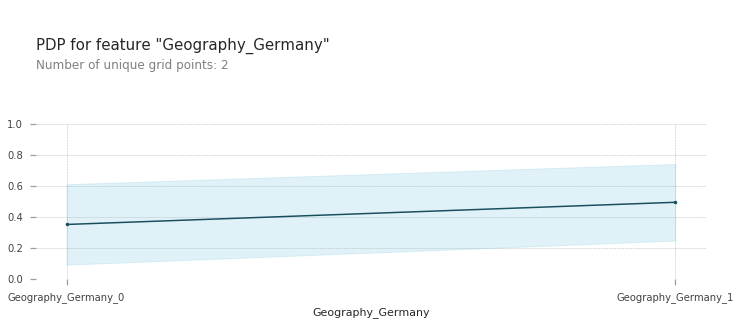

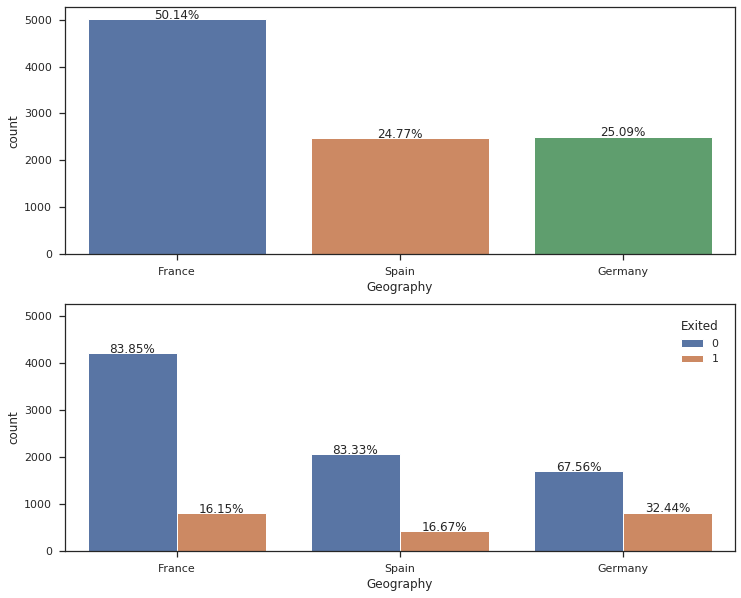

In [123]:
# PDP Plot (Isolation Plot) for 'Geography_Germany' vs. 'Exited'
pdp_goals = pdp.pdp_isolate(model = model_plots, dataset = X_train, model_features = X_train.columns, feature = 'Geography_Germany')
pdp.pdp_plot(pdp_isolate_out = pdp_goals, feature_name = 'Geography_Germany', center = False, figsize = figsize)
plt.ylim(ylim_start, ylim_end)

# Plot created at the EDA session for 'Geography'
percentage_on_bar(feature = "Geography", hue = "Exited", data = df, order = None, hue_order = None, size = (12, 10))

- Looking at the Isolation Plot for 'Geography_Germany', German Customers are more likely to exit the bank services.

- This behavior is matching what was previously visualized ate the EDA session - see barplot above (orange vs. blue bars at the bottom plot). Category 'Germany' for 'Geography' takes a higher percentage of Customer attrition when compared to Customer from France and Spain.

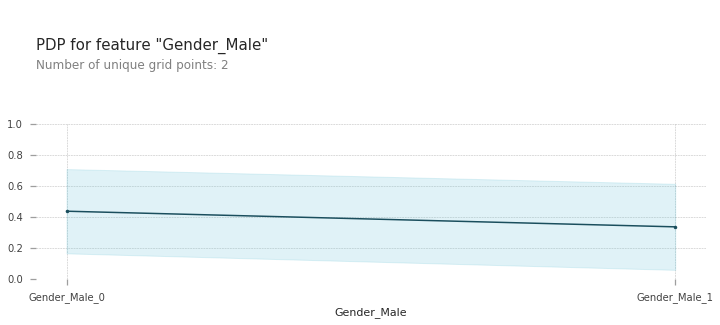

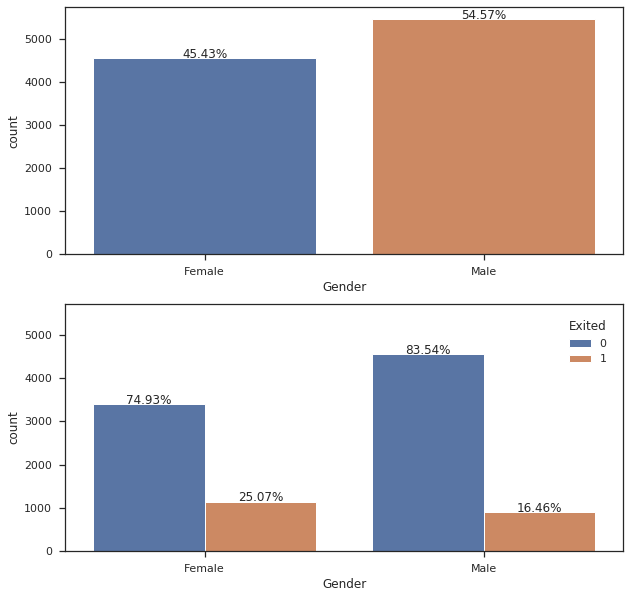

In [124]:
# PDP Plot (Isolation Plot) for 'Gender_Male' vs. 'Exited'
pdp_goals = pdp.pdp_isolate(model = model_plots, dataset = X_train, model_features = X_train.columns, feature = 'Gender_Male')
pdp.pdp_plot(pdp_isolate_out = pdp_goals, feature_name = 'Gender_Male', center = False, figsize = figsize)
plt.ylim(ylim_start, ylim_end)

# Plot created at the EDA session for 'Gender'
percentage_on_bar(feature = "Gender", hue = "Exited", data = df, order = None, hue_order = None, size = (10, 10))

- Looking at the Isolation Plot for 'Gender_Male', male Customers ('Gender_Male' at '1') are slightly less likely to exit the bank services.

- This behavior is matching what was previously visualized ate the EDA session - see barplot above (orange vs. blue bars at the bottom plot). Category 'Male' for 'Gender' takes a lower percentage of Customer attrition.

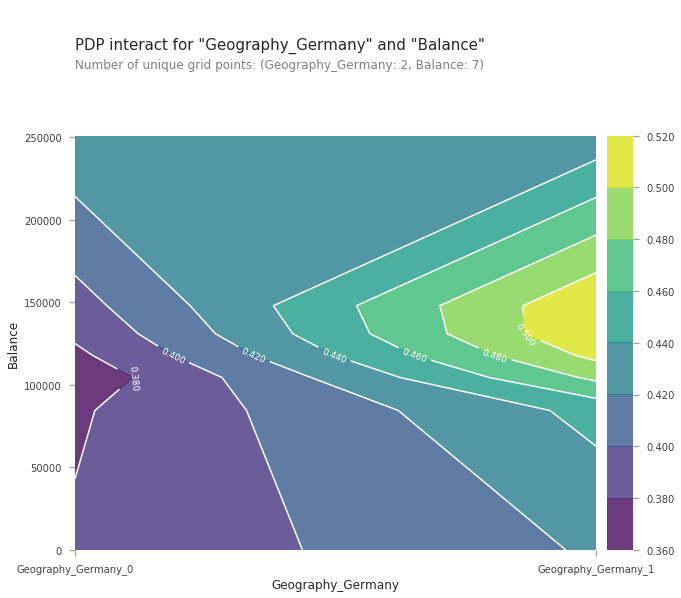

In [125]:
# PDP Plot (Interaction Plot) for 'Geography_Germany' and 'Balance' vs. 'Exited'
pdp_goals = pdp.pdp_interact(model = model_plots, dataset = X_train, model_features = X_train.columns, features = ['Geography_Germany', 'Balance'])
pdp.pdp_interact_plot(pdp_interact_out = pdp_goals, feature_names = ['Geography_Germany', 'Balance'], figsize = (10, 10));

- The Interaction Plot above represents the relationship visualized at the Customer Profile session. Because the German Customers have higher Balance in their bank accounts, this combination results into more likelihood for attrition (yellow region on the plot above).

***
## 8. Conclusion and Key Takeaways <a class="anchor" id="8888"></a>

<span style="font-family: Arial; font-weight:bold;font-size:1.0em;color:blue;">
    
- Final conclusion about the analysis

- Based on the Background and Context:

- In this project, a Neural Network Classification model was built to predict a Customer churn with a bank. This dataset includes the data of Customers who ended up leaving the bank after 06 months. The data for the Features was collected 06 months before the data for the Dependent variable ('Exited'), therefore the main goal for the Classification model is to predict whether a given Customer will leave within the next 06 months. 

- The best model regarding ROC_AUC Score was identified thru the Randomized Search tuning process. A Target Recall of 0.8 was obtained by changing the threshold in the Classification model. The Recall was understood to be the most important metric for the business since an increased Recall would also increase the number of true positives and/or reduce the number of false negatives, lowering the chance to misclassify exited/attrited Customers as existing Customers.

- The most influential variables for the final Classification model (tuned & with threshold modification) were: NumOfProducts, Age, Geography, IsActiveMember, Balance and Gender.

- 'NumberOfProducts' was the most significant variable. Customers with 02 products are less likely to attrition, meaning that offering and sustaining the ownership of 02 products to the Customers could potentially turn them less likely to exit. 

- Regarding 'Age', a special attention should be given to Customers between 45 and 60 yrs. old, who are more likely to exit the bank services.

- On 'IsActiveMember', some campaigns to foster the bank services usage could potentially reduce the likelihood for attrition, since the Customers who are not actively using the bank services are more likely to exit.

- For 'Balance', Customers with more money deposited in their bank accounts are more likely to exit the bank services. A deeper domain knowledge would be required to better understand this pattern since the bank is losing Customers with significant balances which is likely to hit their available capital for lending. 

- German Customers are more likely to exit the bank services. Also, as captured at the Customer Profile session and at the previous session, there's a strong interaction between Customers from Germany and Balance, since none of them have 0(zero) Balance in their accounts (making them to have a higher Balance on average). A more detailed analysis would be required to better understand this pattern.

- Also, Female Customers are more likely to exit the bank than Male Customers.